In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.show()
plt.close()
matplotlib.rcParams.update({"font.size": 16})
default_cycle_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
print(default_cycle_colors)

from cycler import cycler
import numpy as np

import glob
import os

from functools import partial

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

<Figure size 432x288 with 0 Axes>

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [2]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

In [3]:
import copy

In [4]:
import pandas as pd

In [5]:
import phenom

In [6]:
os.sys.path.append("/Users/sebastian.khan/personal/git/stk/ml/waveforms/oct2022/uncertainty")

In [7]:
# custom module
import collocation as col
import utils

In [8]:
import sympy
# sympy.init_printing()
x_sym, a_sym, om_rd = sympy.symbols('x_sym a_sym om_rd')

In [9]:
# custom pn module for inspiral
import pn

In [10]:
# gpr fitting
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, RationalQuadratic, Matern, DotProduct

# custom functions

In [11]:
def get_fdamp_from_q(q):
    """
    estimate ringdown damping frequency from mass-ratio `q`.
    """
    eta = phenom.eta_from_q(q)
    fin_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    fdamp = phenom.remnant.fdamp(eta, 0, 0, fin_spin)
    return fdamp

In [12]:
def get_fring_from_q(q):
    """
    estimate ringdown frequency from mass-ratio `q`.
    """
    eta = phenom.eta_from_q(q)
    fin_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    fring = phenom.remnant.fring(eta, 0, 0, fin_spin)
    return fring

# fit class

In [13]:
class ParameterSpaceFits(object):
    """
    collect together the results from the individual fits and then fit them using GPR
    """
    def __init__(self, wffs):
        
        self.wffs = wffs
        
        # the independent variable
        # if it were aligned spin it would be a (N, 3) matrix
        # where N is the number of waveforms and the columns
        # would be ['q', 'chi1', 'chi2']
        self.xs = np.array([wff.waveform.q for wff in self.wffs])
        
        # useful for setting length of loops
        self.num_collocation_points = {}
        for d in self.wffs[0].collocation_points.keys():
            self.num_collocation_points[d] = len(self.wffs[0].collocation_points[d])
            
        # ys: stores the targets for parameter space fits.
        # it has the same structure as rhs.
        # i.e. the keys are integers and correspond to the
        # derivative order
        # for each key the values are a list of length equal
        # to the number of collocation points
        ys = {}
        # signs: records the sign i.e. -ve or +ve for each data point
        # we need this is we use the log(abs()) transformation to be able
        # to recover the original sign of the data.
        signs = {}
        # loop over derivatives
        for d in self.wffs[0].cm.rhs.keys():
            ys[d] = []
            signs[d] = []
            # loop over collocation points
            for c in range(self.num_collocation_points[d]):
                t = np.array([wff.cm.rhs[d][c] for wff in self.wffs])
                ys[d].append(t)
                s = [np.sign(t_) for t_ in t][0] # assumption: take sign from first waveform
                signs[d].append(s)
        self.ys = ys
        self.signs = signs
        
    def compute_alphas(self):
        """
        sets the self.alphas attribute
        use this when you have multiple observations i.e. multiple mass-ratio x simulations
        for each collocation point we compute the standard deviation over observations
        and use this as a proxy for the uncertainty in that data point.
        for data points where we only have one observation we assume that their uncertainty
        is given by the median value of the distribution of standard deviations
        """
        alphas = {}
        for d in self.wffs[0].cm.rhs.keys():
            alphas[d] = []
            for c in range(self.num_collocation_points[d]):
                # create a dataframe so we can group by easily
                df=pd.DataFrame({'x':self.xs, 'y':self.ys[d][c]})
                # group by mass-ratio and compute standard deviation
                df2=df.groupby(by='x').std()
                df2=df2.rename(columns={'y':'alpha'})
                # remove nans (these are the cases were only one simulation exists)
                # and compute the median value of the distribution of stds
                median_std = np.median(df2['alpha'].values[~np.isnan(df2['alpha'].values)])

                # impute nans with median value
                # join back onto original dataframe so that we have a value of alpha
                # for every data point
                df3=pd.merge(df, df2.fillna(median_std), left_on='x', right_index=True).sort_index()
                alphas[d].append(df3['alpha'].values)
        self.alphas = alphas
        
    def fit(self, GaussianProcessRegressor_kwargs, log_abs_transform=True, use_estimate_alpha=True):
        """
        use_estimate_alpha: if this is true then will use an estimate for alpha based on the data
        """
        if use_estimate_alpha == True:
            assert hasattr(self, 'alphas'), "attribute alphas not set"
        GaussianProcessRegressor_kwargs = GaussianProcessRegressor_kwargs.copy()
        self.log_abs_transform = log_abs_transform
        # loop of self.ys and build a fit
        yhats = {}
        gprs = {}
        # loop over derivatives
        for d in self.ys.keys():
            # loop over collocation points
            yhats[d] = []
            gprs[d] = []
            for c in range(self.num_collocation_points[d]):
                x = self.xs
                y = self.ys[d][c]
                if self.log_abs_transform:
                    y = np.log(np.abs(y))
                if use_estimate_alpha == True:
                    GaussianProcessRegressor_kwargs.update({'alpha':self.alphas[d][c]})
                gpr = GaussianProcessRegressor(**GaussianProcessRegressor_kwargs).fit(x[:,np.newaxis], y)
                gprs[d].append(gpr)
                
        self.gprs = gprs
                
    def predict_sample(self, x, num_samples, random_state=1):
        mus = {}
        for d in self.gprs.keys():
            mus[d] = []
            for c in range(self.num_collocation_points[d]):
                mu = self.gprs[d][c].sample_y(x, num_samples, random_state=random_state)
                if self.log_abs_transform:
                    s = np.array(self.signs[d][c])
                    mu = s * np.exp(mu)
                mus[d].append(mu.T)
        return mus
    
    def predict_mean(self, x):
        mus = {}
        for d in self.gprs.keys():
            mus[d] = []
            for c in range(self.num_collocation_points[d]):
                mu = self.gprs[d][c].predict(x)
                if self.log_abs_transform:
                    s = np.array(self.signs[d][c])
                    mu = s * np.exp(mu)
                # we add a new axis in first position so that we get a shape (1, n) so that it is consistent with 
                # how we treat many samples which a shape (n_samples, n)
                mus[d].append(mu[np.newaxis, :])
                # mus[d].append([mu])
                # mus[d].append(mu)
        return mus

In [14]:
def model_full_phase(q, t, inspiral_model, merger_model, ringdown_model, t_ins=-300, t_m_erd=0, random_state=None, n_samples=1):
# def model_full_phase(q, t, inspiral_model, merger_model, ringdown_model, t_ins=-100, t_m_erd=0, random_state=None, n_samples=1):
    freq = model_full_freq(q, t, inspiral_model, merger_model, ringdown_model, t_ins, t_m_erd, random_state, n_samples)
    ifreq = [IUS(t, f) for f in freq]
    return np.array([ifreq_.antiderivative()(t) for ifreq_ in ifreq])

In [15]:
def model_full_freq(q, t, inspiral_model, merger_model, ringdown_model, t_ins=-300, t_m_erd=0, random_state=None, n_samples=1):
# def model_full_freq(q, t, inspiral_model, merger_model, ringdown_model, t_ins=-100, t_m_erd=0, random_state=None, n_samples=1):
    """
    n_samples is only used when you specify that you want to sample the model and the output shape is going to be (n_samples, n_time)
    if you want to compute the mean model (i.e. use the mean from the GP) then n_samples should be left at 1 and the output will be (1, n_time)
    """
    if random_state == None:
        random_state = np.random.randint(0, 1000000)
        
    y = np.zeros(shape=(n_samples, len(t)))
    
    mask = t < t_ins
    inspiral_times = t[mask]

    mask = (t >= t_ins) & (t < t_m_erd)
    merger_times = t[mask]

    mask = t >= t_m_erd
    ringdown_times = t[mask]

    # compute all inspirals
    pn_kwargs=dict(t=inspiral_times, tc=Tc, eta=phenom.eta_from_q(q), M=1)
    pn_residual = pn.TaylorT3_Omega_new(**pn_kwargs)
    # pn_residual = np.zeros_like(inspiral_times)
    y_ins = inspiral_model(q=q, t=inspiral_times, random_state=random_state, pn_residual=pn_residual, n_samples=n_samples) 

    y_merger = merger_model(q=q, t=merger_times, random_state=random_state, n_samples=n_samples)

    y_ringdown = ringdown_model(q=q, t=ringdown_times, random_state=random_state, n_samples=n_samples)

    return np.concatenate((y_ins, y_merger, y_ringdown), axis=1)

In [16]:
def rd_ansatz_log(t, a, b):
    return np.log(a) - t*b

def connect_rd(t0, y0, fdamp):
    """
    y0 == y(t0)
    this is just fixing the constant offset between the phenom model from peak amplitude
    to about t0=30M.
    We assume the slope is given by the approximately known damping frequency
    We assume exponential decay so it's linear in log-space
    """
    b = fdamp*2*np.pi
    log_a = np.log(y0) + b * t0
    return np.exp(log_a), b

In [17]:
def model_full_amp(q, t, inspiral_model, merger_model, early_ringdown_model, t_ins=-300, t_m_erd=0, t_erd_end=30, random_state=None, n_samples=1):
# def model_full_amp(q, t, inspiral_model, merger_model, early_ringdown_model, t_ins=-100, t_m_erd=0, t_erd_end=30, random_state=None, n_samples=1):
    if random_state == None:
        random_state = np.random.randint(0, 1000000)
        
    fdamp = get_fdamp_from_q(q)
        
    y = np.zeros(shape=(n_samples, len(t)))
    
    mask = t < t_ins
    inspiral_times = t[mask]

    mask = (t >= t_ins) & (t < t_m_erd)
    merger_times = t[mask]

    mask = (t >= t_m_erd) & (t < t_erd_end)
    ringdown_times = t[mask]
    
    mask = t >= t_erd_end
    late_ringdown_times = t[mask]

    # compute all inspirals
    pn_kwargs=dict(t=inspiral_times, tc=Tc, eta=phenom.eta_from_q(q), M=1)
    pn_residual = np.abs(pn.Hhat22_T3(**pn_kwargs))
    # pn_residual = np.zeros_like(inspiral_times)
    y_ins = inspiral_model(q=q, t=inspiral_times, random_state=random_state, pn_residual=pn_residual, n_samples=n_samples) 
    
    # compute all mergers
    y_merger = merger_model(q=q, t=merger_times, random_state=random_state, n_samples=n_samples)
    
    # compute all early ringdowns
    y_early_ringdown = early_ringdown_model(q=q, t=ringdown_times, random_state=random_state, n_samples=n_samples)
    
    # compute all late ringdowns
    # note that the `b`'s only depend on mass-ratio
    # so we only have one of them and not n_samples of them
    
    # this is the value of the final point
    # which we use to connect the exponential ringdown
    y0 = early_ringdown_model(q=q, t=t_erd_end, random_state=random_state, n_samples=n_samples)
    y0 = y0[np.newaxis, :]
    
    a, b = connect_rd(t0=t_erd_end, y0=y0.T, fdamp=fdamp)

    y_late_ringdown = np.exp(rd_ansatz_log(late_ringdown_times, a, b))
    
    return np.concatenate((y_ins, y_merger, y_early_ringdown, y_late_ringdown), axis=1)

In [18]:
def model_full_strain(q, t, amp_model_kwargs, phase_model_kwargs, n_samples=1):
    amp = model_full_amp(q, t, n_samples=n_samples, **amp_model_kwargs)
    phase = model_full_phase(q, t, n_samples=n_samples, **phase_model_kwargs)
    
    h = amp * np.exp(-1.j * phase)
    
    return h

In [19]:
# https://stackoverflow.com/a/31365136/12840171
# need to use cl
import cloudpickle

import os
import glob

In [20]:
# this loads the "models" pickle files
# these are the objects that are ready to be called to generate samples for the model
# input_dir = "model_050123"
input_dir = "model_100123"
model_filenames = glob.glob(os.path.join(input_dir, "models*.cpkl"))
print(model_filenames)

models = {}
for model_filename in model_filenames:
    print(f"loading model: {model_filename}")
    k = model_filename.split("/")[-1].split(".")[0].split("models_")[-1]
    print(f"k: {k}")
    with open(model_filename, 'rb') as my_file:
        models[k] = cloudpickle.load(my_file)

['model_100123/models_amp_ringdown.cpkl', 'model_100123/models_freq_merger.cpkl', 'model_100123/models_freq_ringdown.cpkl', 'model_100123/models_amp_merger.cpkl', 'model_100123/models_freq_inspiral.cpkl', 'model_100123/models_amp_inspiral.cpkl']
loading model: model_100123/models_amp_ringdown.cpkl
k: amp_ringdown
loading model: model_100123/models_freq_merger.cpkl
k: freq_merger
loading model: model_100123/models_freq_ringdown.cpkl
k: freq_ringdown
loading model: model_100123/models_amp_merger.cpkl
k: amp_merger
loading model: model_100123/models_freq_inspiral.cpkl
k: freq_inspiral
loading model: model_100123/models_amp_inspiral.cpkl
k: amp_inspiral


In [21]:
# this loads the "mean_models" pickle files
# these are the objects that are ready to be called to generate the mean prediction of the model

# input_dir = "model_050123"
input_dir = "model_100123"
model_filenames = glob.glob(os.path.join(input_dir, "mean_models*.cpkl"))
print(model_filenames)

mean_models = {}
for model_filename in model_filenames:
    print(f"loading model: {model_filename}")
    k = model_filename.split("/")[-1].split(".")[0].split("mean_models_")[-1]
    print(f"k: {k}")
    with open(model_filename, 'rb') as my_file:
        mean_models[k] = cloudpickle.load(my_file)

['model_100123/mean_models_freq_inspiral.cpkl', 'model_100123/mean_models_amp_merger.cpkl', 'model_100123/mean_models_amp_inspiral.cpkl', 'model_100123/mean_models_freq_merger.cpkl', 'model_100123/mean_models_freq_ringdown.cpkl', 'model_100123/mean_models_amp_ringdown.cpkl']
loading model: model_100123/mean_models_freq_inspiral.cpkl
k: freq_inspiral
loading model: model_100123/mean_models_amp_merger.cpkl
k: amp_merger
loading model: model_100123/mean_models_amp_inspiral.cpkl
k: amp_inspiral
loading model: model_100123/mean_models_freq_merger.cpkl
k: freq_merger
loading model: model_100123/mean_models_freq_ringdown.cpkl
k: freq_ringdown
loading model: model_100123/mean_models_amp_ringdown.cpkl
k: amp_ringdown


In [22]:
mean_models['freq_inspiral']

functools.partial(<function mean_model_base at 0x148726670>, collocation_points={0: [-700, -500, -300]}, ansatz=x_sym**(-1.25) + x_sym**(-1.125) + x_sym**(-1.0), gpr_model=<__main__.ParameterSpaceFits object at 0x148d0fdc0>)

In [23]:
t = np.arange(-600, 100, 1)
q = 1
Tc=1000

In [24]:
yhat = model_full_amp(q, t, inspiral_model=mean_models['amp_inspiral'], merger_model=mean_models['amp_merger'], early_ringdown_model=mean_models['amp_ringdown'], t_ins=-300, t_m_erd=0, t_erd_end=30, random_state=None, n_samples=1)

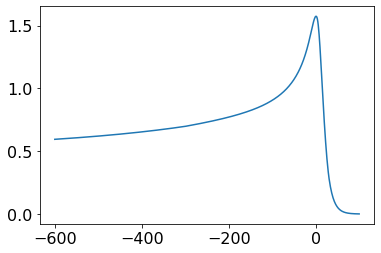

In [25]:
plt.plot(t, yhat[0])

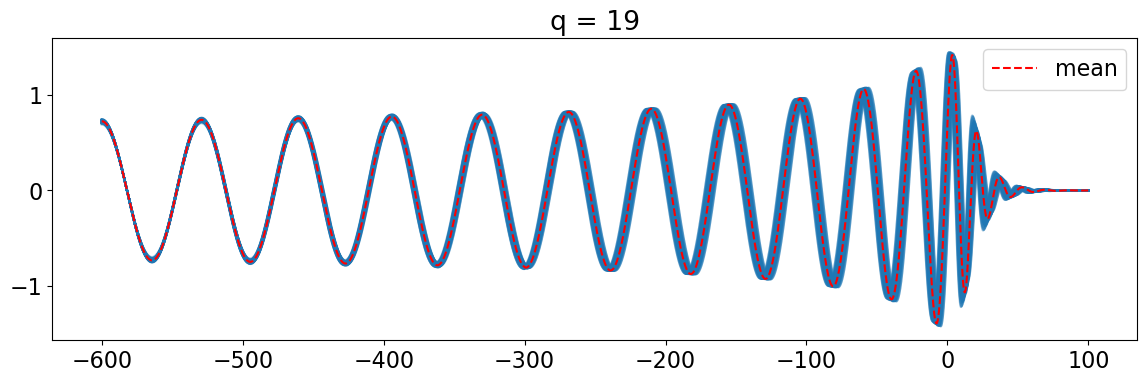

In [26]:
amp_model_kwargs = dict(inspiral_model=models['amp_inspiral'], merger_model=models['amp_merger'], early_ringdown_model=models['amp_ringdown'])
phase_model_kwargs = dict(inspiral_model=models['freq_inspiral'], merger_model=models['freq_merger'], ringdown_model=models['freq_ringdown'])

mean_amp_model_kwargs = dict(inspiral_model=mean_models['amp_inspiral'], merger_model=mean_models['amp_merger'], early_ringdown_model=mean_models['amp_ringdown'])
mean_phase_model_kwargs = dict(inspiral_model=mean_models['freq_inspiral'], merger_model=mean_models['freq_merger'], ringdown_model=mean_models['freq_ringdown'])


n_samples = 100
q = 19
times = np.arange(-600, 100, 0.1)
yys = model_full_strain(q, times, amp_model_kwargs, phase_model_kwargs, n_samples=n_samples)
yys = yys.real

yys_mean = np.array(model_full_strain(q, times, mean_amp_model_kwargs, mean_phase_model_kwargs))[0]
yys_mean = yys_mean.real



plt.figure(figsize=(14, 4), dpi=100)
plt.plot(times, yys.T, c='C0', alpha=0.4);
plt.plot(times, yys_mean, c='r', ls='--', label='mean');
plt.title(f"q = {q}")
plt.legend()
plt.show()
plt.close()

# load data

In [27]:
catalogue_dir = "/Users/sebastian.khan/personal/data/non_spinning_catalogue_dec_2022"

In [28]:
df = pd.read_csv(os.path.join(catalogue_dir, 'metadata.csv'))

In [29]:
times = np.load(os.path.join(catalogue_dir, 'times.npy'))

In [30]:
strains = np.load(os.path.join(catalogue_dir, 'strains.npy'))

In [31]:
strains.shape

(55, 8620)

In [32]:
df.shape

(55, 6)

In [33]:
names_to_drop = [
    'RIT-BBH-0957-n084', # this one is clearly too inaccurate
]

In [34]:
idxs_to_keep = df[~df['name'].isin(names_to_drop)].index

In [35]:
strains = strains[idxs_to_keep]

In [36]:
df = df.iloc[idxs_to_keep].copy().reset_index(drop=True)

In [37]:
amps=np.array([np.abs(strain) for strain in strains])
phases=np.array([np.unwrap(np.angle(strain)) for strain in strains])
freqs=np.array([IUS(times, phase).derivative()(times) for phase in phases])

In [38]:
amps = amps.T / phenom.eta_from_q(df['q'].values)
amps = amps.T

In [39]:
plt.plot(amps.T);

In [40]:
df

name      q     fring     fdamp  duration  t_final
0    q18a0a0c025_96_fine  18.00  0.063334  0.014140    1020.0    465.8
1          q4a0_T_96_384   4.00  0.074330  0.014004    2202.1    229.5
2    q8a0a0_T_96_504n512   8.00  0.067697  0.014104     953.1    430.4
3     q8a0a0c05_T_80_420   8.00  0.067697  0.014104     941.9    259.8
4      q10c25e_T_112_448  10.00  0.066184  0.014119    1157.7    121.6
5          q4a0_T_80_320   4.00  0.074330  0.014004    2199.5    689.1
6        q18a0a0c025_144  18.00  0.063334  0.014140    1028.3     88.8
7   q8a0a0_T_112_588n768   8.00  0.067697  0.014104     957.9    207.8
8        q18a0a0c025_120  18.00  0.063334  0.014140    1027.5    174.7
9         q4a0_T_112_448   4.00  0.074330  0.014004    2202.5    151.8
10     SXS_BBH_0107_Res3   5.00  0.071862  0.014048    7440.1    449.9
11     SXS_BBH_0167_Res5   4.00  0.074330  0.014004    3115.7    404.1
12     SXS_BBH_0107_Res5   5.00  0.071862  0.014048    7465.5    451.5
13     SXS_BBH_0107_Res4   5.00  0.071862  0.014048    7457.2    449.8
14     SXS_BBH_0167_Res3   4.00  0.074330  0.014004    2874.0    403.8
15     SXS_BBH_0169_Res4   2.00  0.083149  0.013774    3458.2    406.7
16     SXS_BBH_0169_Res5   2.00  0.083149  0.013774    3468.3    406.6
17     SXS_BBH_0169_Res3   2.00  0.083149  0.013774    3088.2    406.7
18     SXS_BBH_0180_Res3   1.00  0.088087  0.013596    9359.5    236.6
19     SXS_BBH_0303_Res3  10.00  0.066184  0.014119    3397.6    498.9
20     SXS_BBH_0180_Res2   1.00  0.088087  0.013596    9354.6    236.8
21     SXS_BBH_0303_Res4  10.00  0.066184  0.014119    3433.2    499.1
22     SXS_BBH_0180_Res4   1.00  0.088087  0.013596    9270.5    236.4
23     SXS_BBH_0303_Res5  10.00  0.066184  0.014119    3461.4    499.7
24     RIT-BBH-0416-n140   7.00  0.068739  0.014092    2362.1    363.1
25     RIT-BBH-0084-n100   1.18  0.087761  0.013608    1602.1    396.2
26     RIT-BBH-0152-n120   5.00  0.071862  0.014048    4000.5    557.5
27    RIT-eBBH-1090-n100   1.00  0.088087  0.013596    1493.9    362.0
28    RIT-eBBH-1133-n100   4.00  0.074330  0.014004    2143.1    712.8
29    RIT-eBBH-1241-n100   1.33  0.087138  0.013633    1520.6    335.3
30     RIT-BBH-0942-n120  15.00  0.064066  0.014135    1162.8    330.2
31     RIT-BBH-0112-n100   1.00  0.088087  0.013596   16963.4    419.5
32     RIT-BBH-0139-n140   2.41  0.080777  0.013847    2736.9    423.5
33     RIT-BBH-0373-n140  15.00  0.064066  0.014135    2725.0    437.6
34     RIT-BBH-0792-n120  32.00  0.061687  0.014149    1558.3    191.2
35     RIT-BBH-0090-n100   6.00  0.070079  0.014075    1746.7    392.9
36     RIT-BBH-1020-n144   1.82  0.084262  0.013737    1368.2    249.8
37    RIT-eBBH-1200-n100   2.00  0.083149  0.013774    1637.8    318.1
38     RIT-BBH-0978-n144  10.00  0.066184  0.014119    1963.0    393.4
39     RIT-BBH-1025-n100  32.00  0.061687  0.014149    1474.0    240.2
40                GT0379   2.20  0.081956  0.013812     936.3    616.9
41                GT0378   2.05  0.082845  0.013784     915.7    637.3
42                GT0757   2.25  0.081668  0.013820    1429.1    420.0
43                GT0380   2.35  0.081105  0.013837     957.9    595.3
44                GT0454   4.00  0.074330  0.014004    1855.1    495.1
45                GT0898   1.20  0.087693  0.013611    1793.9    286.8
46                GT0446   2.00  0.083149  0.013774    1378.6    470.3
47                GT0453   3.00  0.077907  0.013924    1599.7    549.9
48                GT0727   1.75  0.084699  0.013722    1330.0    418.7
49                GT0477   1.50  0.086221  0.013667    1286.6    361.9
50                GT0738   1.25  0.087500  0.013619    1252.6    395.9
51                GT0577   5.00  0.071862  0.014048    1281.6    574.2
52                GT0565   2.50  0.080296  0.013861    1484.2    465.0
53                GT0604   6.00  0.070079  0.014075    1496.1    460.8

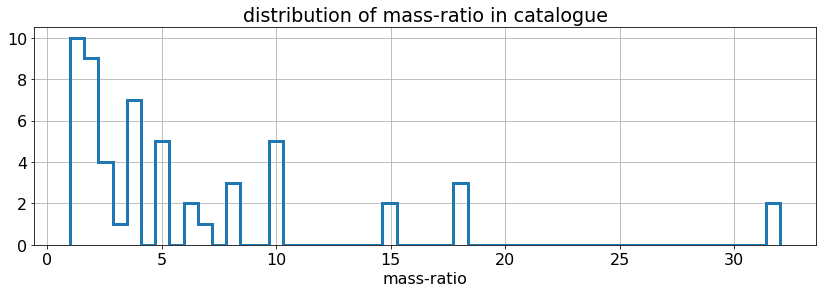

In [41]:
plt.figure(figsize=(14, 4))
plt.hist(df['q'], bins=50, histtype='step', lw=3)
plt.xlabel("mass-ratio");
plt.title("distribution of mass-ratio in catalogue")
plt.grid()

Text(0.5, 1.0, 'q18a0a0c025_96_fine')

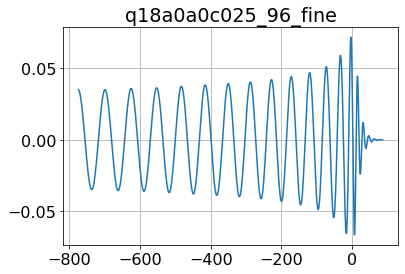

In [42]:
plt.plot(times, strains[0].real)
plt.grid()
plt.title(df.iloc[0]['name'])

# build pycbc interface

In [43]:
import lal

In [44]:
import pycbc.waveform

In [45]:
import pycbc.types

In [46]:
import pycbc.filter
import pycbc.psd


In [47]:
amp_model_kwargs = dict(inspiral_model=models['amp_inspiral'], merger_model=models['amp_merger'], early_ringdown_model=models['amp_ringdown'])
phase_model_kwargs = dict(inspiral_model=models['freq_inspiral'], merger_model=models['freq_merger'], ringdown_model=models['freq_ringdown'])

mean_amp_model_kwargs = dict(inspiral_model=mean_models['amp_inspiral'], merger_model=mean_models['amp_merger'], early_ringdown_model=mean_models['amp_ringdown'])
mean_phase_model_kwargs = dict(inspiral_model=mean_models['freq_inspiral'], merger_model=mean_models['freq_merger'], ringdown_model=mean_models['freq_ringdown'])

In [48]:
def get_nr_strain(strain, times, M, delta_t, distance=1e6 * lal.PC_SI):
    eta = phenom.eta_from_q(q)
    dt_M = times[1] - times[0]
    times_s = phenom.MtoS(times, M)
    # delta_t = phenom.MtoS(dt_M, M)
    
    epoch = phenom.MtoS(times[0], M)
    h = strain * utils.td_amp_scale(60, 1e6 * lal.PC_SI)*lal.SpinWeightedSphericalHarmonic(0,0,-2,2,2)
    hp = h.real
    hc = h.imag
    
    t0 = phenom.MtoS(times[0], M)
    t1 = phenom.MtoS(times[-1], M)
    new_times = np.arange(t0, t1, delta_t)
    hp = IUS(times_s, hp)(new_times)
    hc = IUS(times_s, hc)(new_times)
    
    hp = pycbc.types.TimeSeries(hp, delta_t=delta_t, epoch=epoch)
    hc = pycbc.types.TimeSeries(hc, delta_t=delta_t, epoch=epoch)
    return hp, hc

In [49]:
def gen_model(q, times, M, delta_t, n_samples=-1, distance=1e6 * lal.PC_SI):
    """
    if n_samples == -1 then generates the mean
    otherwise samples
    """
    eta = phenom.eta_from_q(q)
    dt_M = times[1] - times[0]
    times_s = phenom.MtoS(times, M)
    # delta_t = phenom.MtoS(dt_M, M)
    
    epoch = phenom.MtoS(times[0], M)
    
    if n_samples == -1:
        h = model_full_strain(q, times, mean_amp_model_kwargs, mean_phase_model_kwargs)
    else:
        h = model_full_strain(q, times, amp_model_kwargs, phase_model_kwargs, n_samples=n_samples)
        
    h = h*eta
    h = h * utils.td_amp_scale(M, distance) * lal.SpinWeightedSphericalHarmonic(0,0,-2,2,2)
    
    hp = h.real
    hc = h.imag

    t0 = phenom.MtoS(times[0], M)
    t1 = phenom.MtoS(times[-1], M)
    new_times = np.arange(t0, t1, delta_t)

    
    if n_samples == -1:
        hp = IUS(times_s, hp[0])(new_times)
        hc = IUS(times_s, hc[0])(new_times)
        hp = pycbc.types.TimeSeries(hp, delta_t=delta_t, epoch=epoch)
        hc = pycbc.types.TimeSeries(hc, delta_t=delta_t, epoch=epoch)
    else:
        hp = [IUS(times_s, hp_)(new_times) for hp_ in hp]
        hc = [IUS(times_s, hc_)(new_times) for hc_ in hc]
        hp = [pycbc.types.TimeSeries(hp_, delta_t=delta_t, epoch=epoch) for hp_ in hp]
        hc = [pycbc.types.TimeSeries(hc_, delta_t=delta_t, epoch=epoch) for hc_ in hc]
    
    return hp, hc

In [50]:
def compute_match(h1, h2, f_low):
    # Resize the waveforms to the same length
    tlen = max(len(h1), len(h2))
    h1.resize(tlen)
    h2.resize(tlen)

    # Generate the aLIGO ZDHP PSD
    delta_f = 1.0 / h1.duration
    flen = tlen//2 + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_low)

    # Note: This takes a while the first time as an FFT plan is generated
    # subsequent calls are much faster.
    m, _ = pycbc.filter.match(h1, h2, psd=psd, low_frequency_cutoff=f_low)
    return m

# analysis

In [51]:
# original
# df_test = df.query('(q>1 and q<2) or (q>2 and q<=4) or (q>=7 and q<10)')

# new: 10/01/23
df_test = df.query('(q>1 and q<2) or (q>2 and q<=4) or (q>=7 and q<10) or (q>=14 and q<16) or (q>=32 and q<33)')

In [52]:
df_train = df[~df.isin(df_test)].dropna()

In [53]:
df_train

name     q     fring     fdamp  duration  t_final
0   q18a0a0c025_96_fine  18.0  0.063334  0.014140    1020.0    465.8
4     q10c25e_T_112_448  10.0  0.066184  0.014119    1157.7    121.6
6       q18a0a0c025_144  18.0  0.063334  0.014140    1028.3     88.8
8       q18a0a0c025_120  18.0  0.063334  0.014140    1027.5    174.7
10    SXS_BBH_0107_Res3   5.0  0.071862  0.014048    7440.1    449.9
12    SXS_BBH_0107_Res5   5.0  0.071862  0.014048    7465.5    451.5
13    SXS_BBH_0107_Res4   5.0  0.071862  0.014048    7457.2    449.8
15    SXS_BBH_0169_Res4   2.0  0.083149  0.013774    3458.2    406.7
16    SXS_BBH_0169_Res5   2.0  0.083149  0.013774    3468.3    406.6
17    SXS_BBH_0169_Res3   2.0  0.083149  0.013774    3088.2    406.7
18    SXS_BBH_0180_Res3   1.0  0.088087  0.013596    9359.5    236.6
19    SXS_BBH_0303_Res3  10.0  0.066184  0.014119    3397.6    498.9
20    SXS_BBH_0180_Res2   1.0  0.088087  0.013596    9354.6    236.8
21    SXS_BBH_0303_Res4  10.0  0.066184  0.014119    3433.2    499.1
22    SXS_BBH_0180_Res4   1.0  0.088087  0.013596    9270.5    236.4
23    SXS_BBH_0303_Res5  10.0  0.066184  0.014119    3461.4    499.7
26    RIT-BBH-0152-n120   5.0  0.071862  0.014048    4000.5    557.5
27   RIT-eBBH-1090-n100   1.0  0.088087  0.013596    1493.9    362.0
31    RIT-BBH-0112-n100   1.0  0.088087  0.013596   16963.4    419.5
35    RIT-BBH-0090-n100   6.0  0.070079  0.014075    1746.7    392.9
37   RIT-eBBH-1200-n100   2.0  0.083149  0.013774    1637.8    318.1
38    RIT-BBH-0978-n144  10.0  0.066184  0.014119    1963.0    393.4
46               GT0446   2.0  0.083149  0.013774    1378.6    470.3
51               GT0577   5.0  0.071862  0.014048    1281.6    574.2
53               GT0604   6.0  0.070079  0.014075    1496.1    460.8

In [54]:
df_test

name      q     fring     fdamp  duration  t_final
1          q4a0_T_96_384   4.00  0.074330  0.014004    2202.1    229.5
2    q8a0a0_T_96_504n512   8.00  0.067697  0.014104     953.1    430.4
3     q8a0a0c05_T_80_420   8.00  0.067697  0.014104     941.9    259.8
5          q4a0_T_80_320   4.00  0.074330  0.014004    2199.5    689.1
7   q8a0a0_T_112_588n768   8.00  0.067697  0.014104     957.9    207.8
9         q4a0_T_112_448   4.00  0.074330  0.014004    2202.5    151.8
11     SXS_BBH_0167_Res5   4.00  0.074330  0.014004    3115.7    404.1
14     SXS_BBH_0167_Res3   4.00  0.074330  0.014004    2874.0    403.8
24     RIT-BBH-0416-n140   7.00  0.068739  0.014092    2362.1    363.1
25     RIT-BBH-0084-n100   1.18  0.087761  0.013608    1602.1    396.2
28    RIT-eBBH-1133-n100   4.00  0.074330  0.014004    2143.1    712.8
29    RIT-eBBH-1241-n100   1.33  0.087138  0.013633    1520.6    335.3
30     RIT-BBH-0942-n120  15.00  0.064066  0.014135    1162.8    330.2
32     RIT-BBH-0139-n140   2.41  0.080777  0.013847    2736.9    423.5
33     RIT-BBH-0373-n140  15.00  0.064066  0.014135    2725.0    437.6
34     RIT-BBH-0792-n120  32.00  0.061687  0.014149    1558.3    191.2
36     RIT-BBH-1020-n144   1.82  0.084262  0.013737    1368.2    249.8
39     RIT-BBH-1025-n100  32.00  0.061687  0.014149    1474.0    240.2
40                GT0379   2.20  0.081956  0.013812     936.3    616.9
41                GT0378   2.05  0.082845  0.013784     915.7    637.3
42                GT0757   2.25  0.081668  0.013820    1429.1    420.0
43                GT0380   2.35  0.081105  0.013837     957.9    595.3
44                GT0454   4.00  0.074330  0.014004    1855.1    495.1
45                GT0898   1.20  0.087693  0.013611    1793.9    286.8
47                GT0453   3.00  0.077907  0.013924    1599.7    549.9
48                GT0727   1.75  0.084699  0.013722    1330.0    418.7
49                GT0477   1.50  0.086221  0.013667    1286.6    361.9
50                GT0738   1.25  0.087500  0.013619    1252.6    395.9
52                GT0565   2.50  0.080296  0.013861    1484.2    465.0

In [55]:
df['set'] = None

In [56]:
df.loc[df.index.isin(df_train.index), 'set']="train"
df.loc[df.index.isin(df_test.index), 'set']="test"

In [57]:
df

name      q     fring     fdamp  duration  t_final    set
0    q18a0a0c025_96_fine  18.00  0.063334  0.014140    1020.0    465.8  train
1          q4a0_T_96_384   4.00  0.074330  0.014004    2202.1    229.5   test
2    q8a0a0_T_96_504n512   8.00  0.067697  0.014104     953.1    430.4   test
3     q8a0a0c05_T_80_420   8.00  0.067697  0.014104     941.9    259.8   test
4      q10c25e_T_112_448  10.00  0.066184  0.014119    1157.7    121.6  train
5          q4a0_T_80_320   4.00  0.074330  0.014004    2199.5    689.1   test
6        q18a0a0c025_144  18.00  0.063334  0.014140    1028.3     88.8  train
7   q8a0a0_T_112_588n768   8.00  0.067697  0.014104     957.9    207.8   test
8        q18a0a0c025_120  18.00  0.063334  0.014140    1027.5    174.7  train
9         q4a0_T_112_448   4.00  0.074330  0.014004    2202.5    151.8   test
10     SXS_BBH_0107_Res3   5.00  0.071862  0.014048    7440.1    449.9  train
11     SXS_BBH_0167_Res5   4.00  0.074330  0.014004    3115.7    404.1   test
12     SXS_BBH_0107_Res5   5.00  0.071862  0.014048    7465.5    451.5  train
13     SXS_BBH_0107_Res4   5.00  0.071862  0.014048    7457.2    449.8  train
14     SXS_BBH_0167_Res3   4.00  0.074330  0.014004    2874.0    403.8   test
15     SXS_BBH_0169_Res4   2.00  0.083149  0.013774    3458.2    406.7  train
16     SXS_BBH_0169_Res5   2.00  0.083149  0.013774    3468.3    406.6  train
17     SXS_BBH_0169_Res3   2.00  0.083149  0.013774    3088.2    406.7  train
18     SXS_BBH_0180_Res3   1.00  0.088087  0.013596    9359.5    236.6  train
19     SXS_BBH_0303_Res3  10.00  0.066184  0.014119    3397.6    498.9  train
20     SXS_BBH_0180_Res2   1.00  0.088087  0.013596    9354.6    236.8  train
21     SXS_BBH_0303_Res4  10.00  0.066184  0.014119    3433.2    499.1  train
22     SXS_BBH_0180_Res4   1.00  0.088087  0.013596    9270.5    236.4  train
23     SXS_BBH_0303_Res5  10.00  0.066184  0.014119    3461.4    499.7  train
24     RIT-BBH-0416-n140   7.00  0.068739  0.014092    2362.1    363.1   test
25     RIT-BBH-0084-n100   1.18  0.087761  0.013608    1602.1    396.2   test
26     RIT-BBH-0152-n120   5.00  0.071862  0.014048    4000.5    557.5  train
27    RIT-eBBH-1090-n100   1.00  0.088087  0.013596    1493.9    362.0  train
28    RIT-eBBH-1133-n100   4.00  0.074330  0.014004    2143.1    712.8   test
29    RIT-eBBH-1241-n100   1.33  0.087138  0.013633    1520.6    335.3   test
30     RIT-BBH-0942-n120  15.00  0.064066  0.014135    1162.8    330.2   test
31     RIT-BBH-0112-n100   1.00  0.088087  0.013596   16963.4    419.5  train
32     RIT-BBH-0139-n140   2.41  0.080777  0.013847    2736.9    423.5   test
33     RIT-BBH-0373-n140  15.00  0.064066  0.014135    2725.0    437.6   test
34     RIT-BBH-0792-n120  32.00  0.061687  0.014149    1558.3    191.2   test
35     RIT-BBH-0090-n100   6.00  0.070079  0.014075    1746.7    392.9  train
36     RIT-BBH-1020-n144   1.82  0.084262  0.013737    1368.2    249.8   test
37    RIT-eBBH-1200-n100   2.00  0.083149  0.013774    1637.8    318.1  train
38     RIT-BBH-0978-n144  10.00  0.066184  0.014119    1963.0    393.4  train
39     RIT-BBH-1025-n100  32.00  0.061687  0.014149    1474.0    240.2   test
40                GT0379   2.20  0.081956  0.013812     936.3    616.9   test
41                GT0378   2.05  0.082845  0.013784     915.7    637.3   test
42                GT0757   2.25  0.081668  0.013820    1429.1    420.0   test
43                GT0380   2.35  0.081105  0.013837     957.9    595.3   test
44                GT0454   4.00  0.074330  0.014004    1855.1    495.1   test
45                GT0898   1.20  0.087693  0.013611    1793.9    286.8   test
46                GT0446   2.00  0.083149  0.013774    1378.6    470.3  train
47                GT0453   3.00  0.077907  0.013924    1599.7    549.9   test
48                GT0727   1.75  0.084699  0.013722    1330.0    418.7   test
49                GT0477   1.50  0.086221  0.013667    1286.6    361.9   test
50                GT0738   1.25  0.087500 

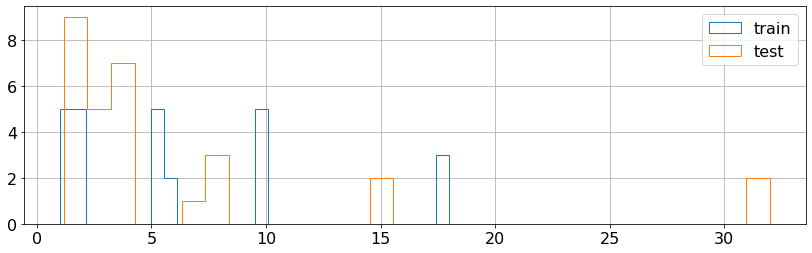

In [58]:
plt.figure(figsize=(14,4))
plt.hist(df.query("set == 'train'")['q'], histtype='step', bins=30, label='train')
plt.hist(df.query("set == 'test'")['q'], histtype='step', bins=30, label='test')
plt.grid()
plt.legend()

In [59]:
# times_sec = phenom.MtoS(times, 60)
# delta_t = times_sec[1]-times_sec[0]
# delta_t

In [60]:
delta_t = 1/4096.

In [61]:
# hp1, hc1 = get_nr_strain(strains[X_.index[0]], times, M, 1/4096)

In [62]:
# plt.plot(hp1.sample_times, hp1)

In [63]:
hp1, hc1 = gen_model(1, times, 60, 1/4096, n_samples=-1)

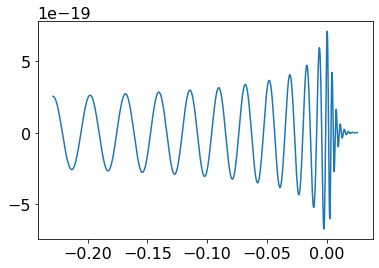

In [64]:
plt.plot(hp1.sample_times, hp1)

In [65]:
# for the training set compute the match between NR simluations that have duplicates

In [66]:
# we need to explicitly say which is the most accurate waveform
# or at least what we belive to be the most accurate...
# or we compute the matrix of matches

In [67]:
# matrix of matches
M=60
X_ = df.query(f'q == {5}')

ma = np.zeros(shape=(len(X_), len(X_)))
for i, i_wf in enumerate(X_.index):
    hp1, hc1 = get_nr_strain(strains[i_wf], times, M, delta_t)
    for j, j_wf in enumerate(X_.index):
        if j > i:
            hp2, hc2 = get_nr_strain(strains[j_wf], times, M, delta_t)
            val = compute_match(hp1, hp2, 60)
            ma[i,j] = val
        


#

In [68]:
X_

name    q     fring     fdamp  duration  t_final    set
10  SXS_BBH_0107_Res3  5.0  0.071862  0.014048    7440.1    449.9  train
12  SXS_BBH_0107_Res5  5.0  0.071862  0.014048    7465.5    451.5  train
13  SXS_BBH_0107_Res4  5.0  0.071862  0.014048    7457.2    449.8  train
26  RIT-BBH-0152-n120  5.0  0.071862  0.014048    4000.5    557.5  train
51             GT0577  5.0  0.071862  0.014048    1281.6    574.2  train

In [69]:
ma

array([[0.        , 0.99994959, 0.99989239, 0.99949167, 0.99921799],
       [0.        , 0.        , 0.99998907, 0.99974678, 0.99946761],
       [0.        , 0.        , 0.        , 0.9998345 , 0.99954442],
       [0.        , 0.        , 0.        , 0.        , 0.99944173],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

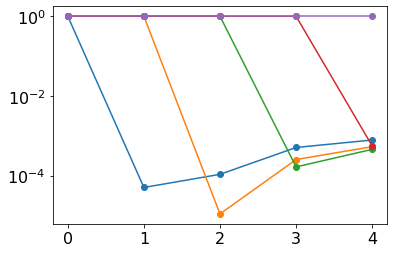

In [70]:
plt.plot(1-ma.T, 'o-')
plt.yscale('log')
# plt.ylim(1e-6,1e-2)

In [71]:
nr_nr_matches = {}
qs_nr=[]
vals_nr=[]
for q in df['q'].unique():
    X_ = df.query(f'q == {q}')
    if len(X_) > 1:
        nr_nr_matches[q] = []
        wf1 = strains[X_.index[0]].real
        hp1, hc1 = get_nr_strain(strains[X_.index[0]], times, M, delta_t)
        for i in X_.index[1:]:
            hp2, hc2 = get_nr_strain(strains[i], times, M, delta_t)
            val = compute_match(hp1, hp2, 60)
            nr_nr_matches[q].append(val)
            qs_nr.append(q)
            vals_nr.append(val)
qs_nr = np.array(qs_nr)
vals_nr = np.array(vals_nr)

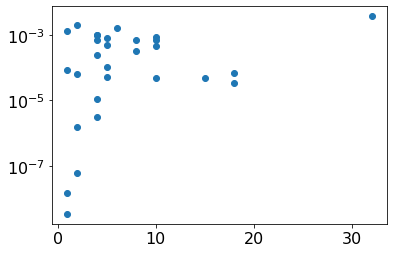

In [72]:
plt.plot(qs_nr, 1-vals_nr, 'o')
plt.yscale('log')

In [73]:
nr_nr_matches

{18.0: [0.9999329642150064, 0.9999654420040622],
 4.0: [0.9999888015832112,
  0.9999967798037662,
  0.9993181507491312,
  0.9989789701470682,
  0.9989956710143069,
  0.9997541673658049],
 8.0: [0.9992886347190197, 0.9996682741333393],
 10.0: [0.9991643068676713,
  0.9993201757864497,
  0.9995418801368194,
  0.999952402736112],
 5.0: [0.9999495909358085,
  0.9998923872518529,
  0.9994916698404296,
  0.9992179854802348],
 2.0: [0.9999999403572314,
  0.9999984962359585,
  0.9999379559387711,
  0.9979958595596213],
 1.0: [0.9999999965347277,
  0.9999999849891753,
  0.9999128121138703,
  0.9987138918410241],
 15.0: [0.9999507866020712],
 32.0: [0.9962925098490316],
 6.0: [0.998423856026114]}

In [74]:
qs_nr_median=[]
vals_nr_median=[]
vals_nr_min=[]
vals_nr_max=[]
for i, k in enumerate(nr_nr_matches.keys()):
    qs_nr_median.append(k)
    vals_nr_median.append(np.median(nr_nr_matches[k]))
    vals_nr_min.append(np.min(nr_nr_matches[k]))
    vals_nr_max.append(np.max(nr_nr_matches[k]))
df_nr_median = pd.DataFrame({'q':qs_nr_median, 'v':vals_nr_median, 'v_min':vals_nr_min, 'v_max':vals_nr_max})

In [75]:
df_nr_median

q         v     v_min     v_max
0  18.0  0.999949  0.999933  0.999965
1   4.0  0.999536  0.998979  0.999997
2   8.0  0.999478  0.999289  0.999668
3  10.0  0.999431  0.999164  0.999952
4   5.0  0.999692  0.999218  0.999950
5   2.0  0.999968  0.997996  1.000000
6   1.0  0.999956  0.998714  1.000000
7  15.0  0.999951  0.999951  0.999951
8  32.0  0.996293  0.996293  0.996293
9   6.0  0.998424  0.998424  0.998424

In [76]:
%%time
M = 60
f_lower = 22
# lower_freq_cut_off = 40
lower_freq_cut_off = 30

delta_t = 1/4096.

# loop over NR waveforms, loop over approximants

approximants = ['mean_model', 'SEOBNRv4', 'TEOBResumS', 'IMRPhenomD', 'IMRPhenomT', 'IMRPhenomXP', 'NRSur7dq4', 'IMRPhenomC']

results = []

for i in range(len(df)):
# for i in [1,2]:
    d = {}
    
    q = df.iloc[i]['q']
    m1, m2 = phenom.m1_m2_M_q(M, q)
    
    for approximant in approximants:
        
        if approximant == 'mean_model':
            hp_nr, hc_nr = get_nr_strain(strains[i], times, M, delta_t)
            hp, hc = gen_model(q, times, M, delta_t, n_samples=-1)
            match_val = compute_match(hp_nr, hp, lower_freq_cut_off)
        else:

            try:
                hp_nr, hc_nr = get_nr_strain(strains[i], times, M, delta_t)
                hp, hc = pycbc.waveform.get_td_waveform(approximant=approximant, mass1=m1, mass2=m2, f_lower=f_lower, mode_array=[[2,2], [2,-2]], delta_t=delta_t)
                
                
                # all this stuff is because the strains array is only defined between -800 and 80M so we have to cut the pycbc
                # waveform to this domain to get a robust comparison
                h1, h2 = pycbc.waveform.utils.coalign_waveforms(hp_nr, hp, low_frequency_cutoff=30)
                
                t0_ = h1.sample_times[(h1.sample_times > phenom.MtoS(-700, 60)) & (h1.sample_times < phenom.MtoS(80, 60))]
                y0_ = h1.numpy()[(h1.sample_times > phenom.MtoS(-700, 60)) & (h1.sample_times < phenom.MtoS(80, 60))]

                t1_ = h2.sample_times[(h2.sample_times > phenom.MtoS(-700, 60)) & (h2.sample_times < phenom.MtoS(80, 60))]
                y1_ = h2.numpy()[(h2.sample_times > phenom.MtoS(-700, 60)) & (h2.sample_times < phenom.MtoS(80, 60))]
                
                hp_nr = pycbc.types.TimeSeries(y0_, delta_t=delta_t)
                hp = pycbc.types.TimeSeries(y1_, delta_t=delta_t)
                
                # plt.figure()
                # plt.plot(t0_, y0_)
                # plt.plot(t1_, y1_)
                # plt.title(f"{approximant}, {df.iloc[i]['name']}")
                # plt.show()
                # plt.close()
                
                
                match_val = compute_match(hp_nr, hp, lower_freq_cut_off)
            except:
                match_val = np.nan

    #         if approximant == 'NRSur7dq4' and q > 6:
    #             match_val = np.nan
    #         else:
    #             hp, hc = pycbc.waveform.get_td_waveform(approximant=approximant, mass1=m1, mass2=m2, f_lower=f_lower, mode_array=[[2,2], [2,-2]], delta_t=delta_t)
    #             match_val = compute_match(hp_nr, hp, lower_freq_cut_off)
        d[approximant] = match_val
    
    results.append(d)

XLAL Error - PrecessingNRSur_IntegrateDynamics (/Users/runner/miniforge3/conda-bld/lalsimulation-split_1655125357599/work/lib/LALSimIMRPrecessingNRSur.c:1705): Too much extrapolation. Mass ratio q = 18.0000 > 6.0100, the maximum allowed value.

XLAL Error - PrecessingNRSur_IntegrateDynamics (/Users/runner/miniforge3/conda-bld/lalsimulation-split_1655125357599/work/lib/LALSimIMRPrecessingNRSur.c:1705): Input domain error
XLAL Error - XLALSimInspiralPrecessingNRSurPolarizations (/Users/runner/miniforge3/conda-bld/lalsimulation-split_1655125357599/work/lib/LALSimIMRPrecessingNRSur.c:2295): fMin should be 0 or >= 28.35885899 for this configuration, got 22.00000000
XLAL Error - XLALSimInspiralPrecessingNRSurPolarizations (/Users/runner/miniforge3/conda-bld/lalsimulation-split_1655125357599/work/lib/LALSimIMRPrecessingNRSur.c:2295): Input domain error
XLAL Error - PrecessingNRSur_IntegrateDynamics (/Users/runner/miniforge3/conda-bld/lalsimulation-split_1655125357599/work/lib/LALSimIMRPrecess

CPU times: user 33.7 s, sys: 15.1 s, total: 48.8 s
Wall time: 16.2 s


In [77]:
df_results = pd.DataFrame({
    f'{approx}':[r[approx] for r in results] for approx in approximants
})

In [78]:
df_results = pd.merge(df, df_results, left_index=True, right_index=True, how='inner')

In [79]:
# should probably remove the q15 n84 case
df_results.query('q==15')

name     q     fring     fdamp  duration  t_final   set  \
30  RIT-BBH-0942-n120  15.0  0.064066  0.014135    1162.8    330.2  test   
33  RIT-BBH-0373-n140  15.0  0.064066  0.014135    2725.0    437.6  test   

    mean_model  SEOBNRv4  TEOBResumS  IMRPhenomD  IMRPhenomT  IMRPhenomXP  \
30    0.998188  0.999124    0.999139    0.994624    0.999215     0.999521   
33    0.997950  0.999278    0.999255    0.995113    0.999272     0.999662   

    NRSur7dq4  IMRPhenomC  
30        NaN    0.581081  
33        NaN    0.579312

In [80]:
np.array(approximants)[~(np.array(approximants)=='IMRPhenomC')]

array(['mean_model', 'SEOBNRv4', 'TEOBResumS', 'IMRPhenomD', 'IMRPhenomT',
       'IMRPhenomXP', 'NRSur7dq4'], dtype='<U11')

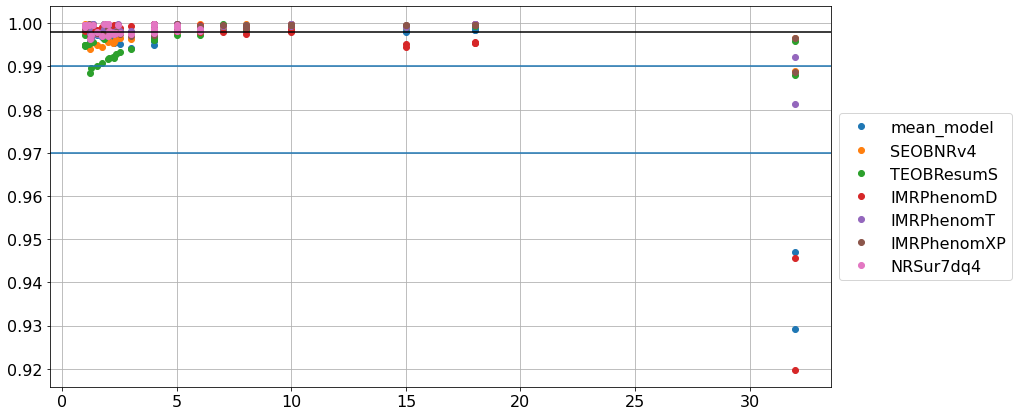

In [81]:
plt.figure(figsize=(14, 7))
# for approx in approximants:
for approx in np.array(approximants)[~(np.array(approximants)=='IMRPhenomC')]:
    plt.plot(df_results['q'], df_results[approx], 'o', label=approx)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(0.99)
plt.axhline(0.97)
plt.grid()
# for q_ in df.query("set == 'train'")['q']:
#     plt.axvline(q_, c='r', ymax=0.02)
    
# for q_ in df.query("set == 'test'")['q']:
#     plt.axvline(q_, c='g', ymax=0.02)

plt.axhline(0.998, c='k')

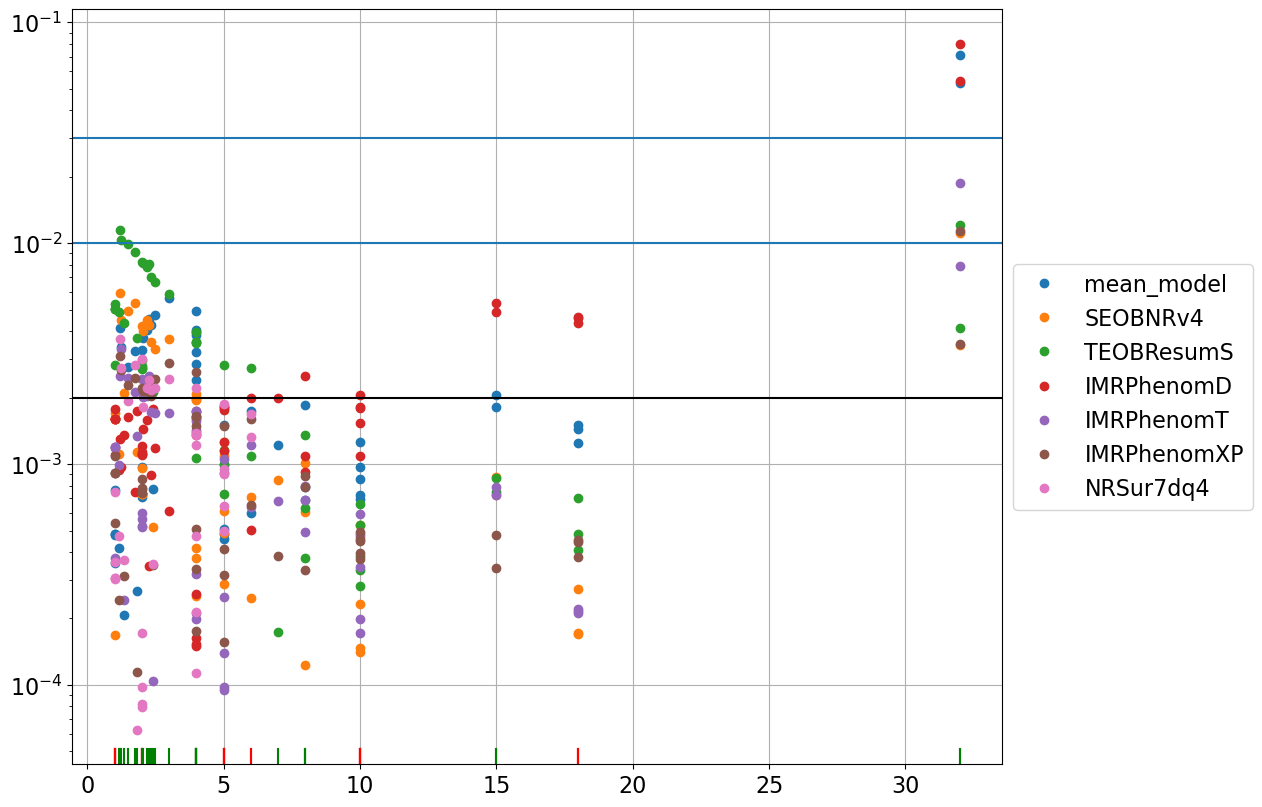

In [82]:
plt.figure(figsize=(12, 10), dpi=100)
# for approx in approximants:
for approx in np.array(approximants)[~(np.array(approximants)=='IMRPhenomC')]:
    plt.plot(df_results['q'], 1-df_results[approx], 'o', label=approx)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.axhline(1-0.99)
plt.axhline(1-0.97)
plt.grid()
# plt.xscale('log')

for q_ in df.query("set == 'train'")['q']:
    plt.axvline(q_, c='r', ymax=0.02)
    
for q_ in df.query("set == 'test'")['q']:
    plt.axvline(q_, c='g', ymax=0.02)
    
plt.axhline(1-0.998, c='k')

In [83]:
def plot_loghist(x, bins, label=''):
    """https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib"""
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins, histtype='step', label=label, lw=2)
    plt.xscale('log')

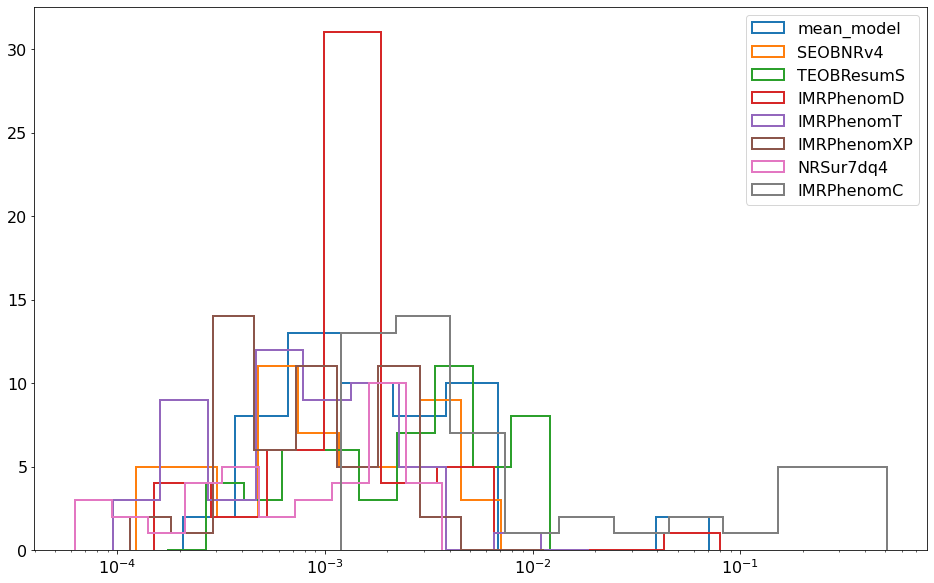

In [84]:
plt.figure(figsize=(16,10))
for approx in approximants:
    plot_loghist(1-df_results[approx][~df_results[approx].isna()], 10, approx)
plt.legend(approximants)

# analysis of PhenProb

In [85]:
def compute_phenprob_samples_match(df, strains, M=60, f_lower=22, lower_freq_cut_off = 30, delta_t=1/4096., n_samples=100):
    """
    computes match of samples with NR to get true measure of uncertainty
    """
    
    names=[]
    results = np.zeros(shape=[len(df), n_samples])
    
    for i in range(len(df)):
        names.append(df.iloc[i]['name'])


        q = df.iloc[i]['q']
        m1, m2 = phenom.m1_m2_M_q(M, q)

        hp_nr, hc_nr = get_nr_strain(strains[i], times, M, delta_t)
        hp, hc = gen_model(q, times, M, delta_t, n_samples=n_samples)
        match_vals = [compute_match(hp_nr, hp_, lower_freq_cut_off) for hp_ in hp]
        results[i] = match_vals
        
    return results, names

In [86]:
def compute_phenprob_samples_match_with_self_mean(qs, M=60, f_lower=22, lower_freq_cut_off = 30, delta_t=1/4096., n_samples=100):
    """
    computes match of samples with mean to get a measure of self uncertainty
    """
    
    results = np.zeros(shape=[len(qs), n_samples])
    
    for i in range(len(qs)):
        q = qs[i]
        m1, m2 = phenom.m1_m2_M_q(M, q)

        hp_mean, hc_mean = gen_model(q, times, M, delta_t, n_samples=-1)
        hp, hc = gen_model(q, times, M, delta_t, n_samples=n_samples)
        match_vals = [compute_match(hp_mean, hp_, lower_freq_cut_off) for hp_ in hp]
        results[i] = match_vals
        
    return results

In [87]:
%%time
phenprob_samples_matches, phenprob_samples_names = compute_phenprob_samples_match(df, strains, n_samples=100)

CPU times: user 1min 58s, sys: 1.83 s, total: 2min
Wall time: 2min 1s


In [88]:
df.query("q==32")

name     q     fring     fdamp  duration  t_final   set
34  RIT-BBH-0792-n120  32.0  0.061687  0.014149    1558.3    191.2  test
39  RIT-BBH-1025-n100  32.0  0.061687  0.014149    1474.0    240.2  test

In [89]:
%%time
# target q=32 specifically
phenprob_samples_matches_q32, phenprob_samples_names_q32 = compute_phenprob_samples_match(df.query("q==32"), strains[df.query("q==32").index], n_samples=100)

CPU times: user 4.43 s, sys: 71.8 ms, total: 4.5 s
Wall time: 4.52 s


In [90]:
phenprob_samples_names_q32

['RIT-BBH-0792-n120', 'RIT-BBH-1025-n100']

In [91]:
%%time
phenprob_sampless_self_matches = compute_phenprob_samples_match_with_self_mean(df_results['q'])

CPU times: user 1min 59s, sys: 1.97 s, total: 2min 1s
Wall time: 2min 1s


In [92]:
df.shape

(54, 7)

In [93]:
%%time
qs_fine = np.arange(1, 40, 0.2)
phenprob_sampless_self_matches_fine = compute_phenprob_samples_match_with_self_mean(qs_fine)

CPU times: user 7min 16s, sys: 7.69 s, total: 7min 24s
Wall time: 7min 25s


In [94]:
qs_fine.shape

(195,)

In [95]:
phenprob_samples_matches.shape

(54, 100)

(0.97, 1.01)

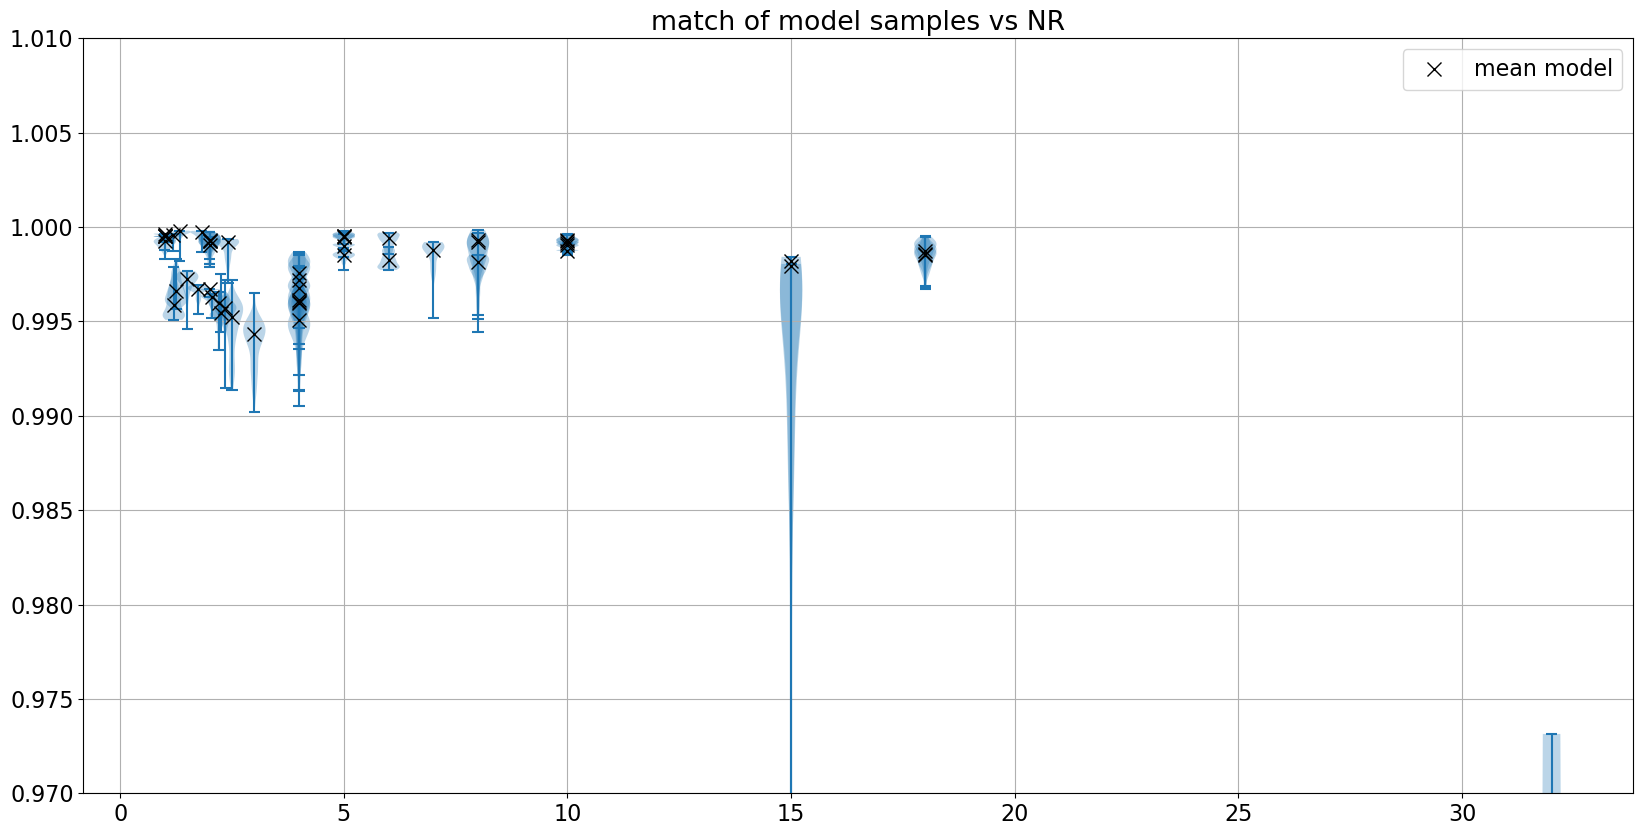

In [96]:
plt.figure(figsize=(20,10), dpi=100)
plt.violinplot(phenprob_samples_matches.T, positions=df['q'].values);
plt.plot(df_results['q'], df_results['mean_model'], 'x', c='k', markersize=10, label='mean model')
plt.grid()
plt.title("match of model samples vs NR")
plt.legend()
plt.ylim(0.97, 1.01)

In [97]:
plt.figure(figsize=(20,10), dpi=100)
plt.violinplot(phenprob_samples_matches_q32.T, positions=df.query("q==32")['q'].values);
plt.plot(df_results.query("q>=18")['q'], df_results.query("q>=18")['mean_model'], 'x', c='k', markersize=10, label='mean model')
plt.grid()
plt.title("match of model samples vs NR")
plt.legend()
# plt.ylim(0.97, 1.01)

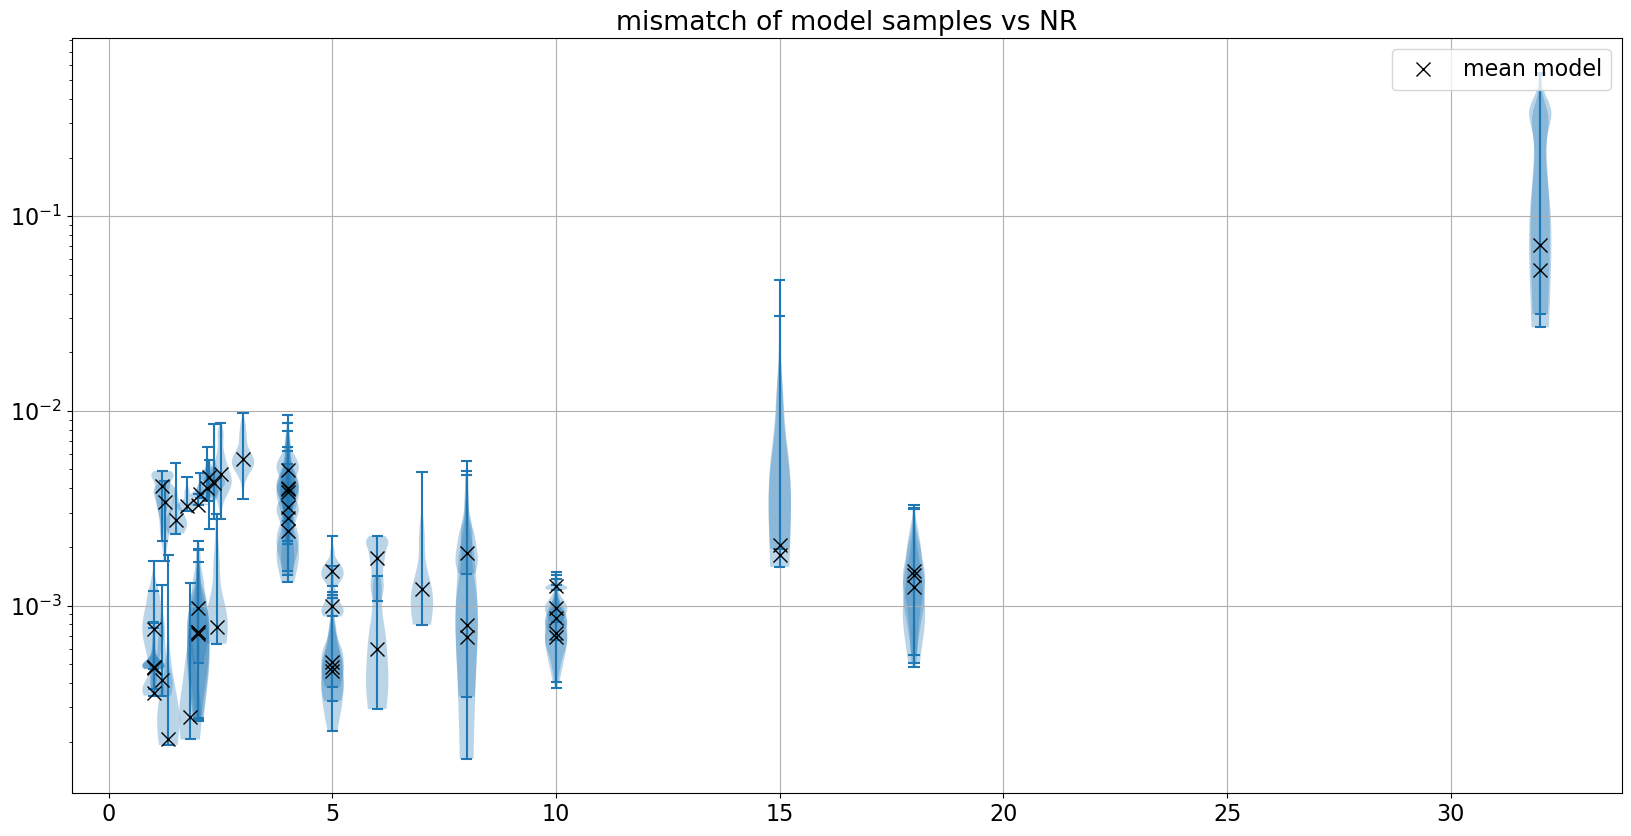

In [98]:
plt.figure(figsize=(20,10), dpi=100)
plt.violinplot(1-phenprob_samples_matches.T, positions=df['q'].values);
plt.plot(df_results['q'], 1-df_results['mean_model'], 'x', c='k', markersize=10, label='mean model')
plt.yscale('log')
plt.grid()
plt.title("mismatch of model samples vs NR")
plt.legend()

In [99]:
match_mu_est = (phenprob_sampless_self_matches).mean(1)
match_err_est = (phenprob_sampless_self_matches).std(1)


# put in format for plt.errorbar
match_err_min_max = np.column_stack((phenprob_sampless_self_matches.min(1), phenprob_sampless_self_matches.max(1)))

match_err_width = match_err_min_max[:,1] - match_err_min_max[:,0]

match_err_min_max = match_err_min_max.T
match_yerr = np.row_stack([match_mu_est-match_err_min_max[0], match_err_min_max[1]-match_mu_est])



In [100]:
plt.figure(figsize=(20,10), dpi=100)
# plt.errorbar(df_results['q'], match_mu_est, yerr=match_err_est, fmt='o')
plt.errorbar(df_results['q'], match_mu_est, yerr=match_yerr, fmt='o')

plt.grid()
plt.legend()
plt.ylim(0.99, 1.01)
# plt.yscale('log')
# plt.ylim(1e-8, 1)

(0.99, 1.01)

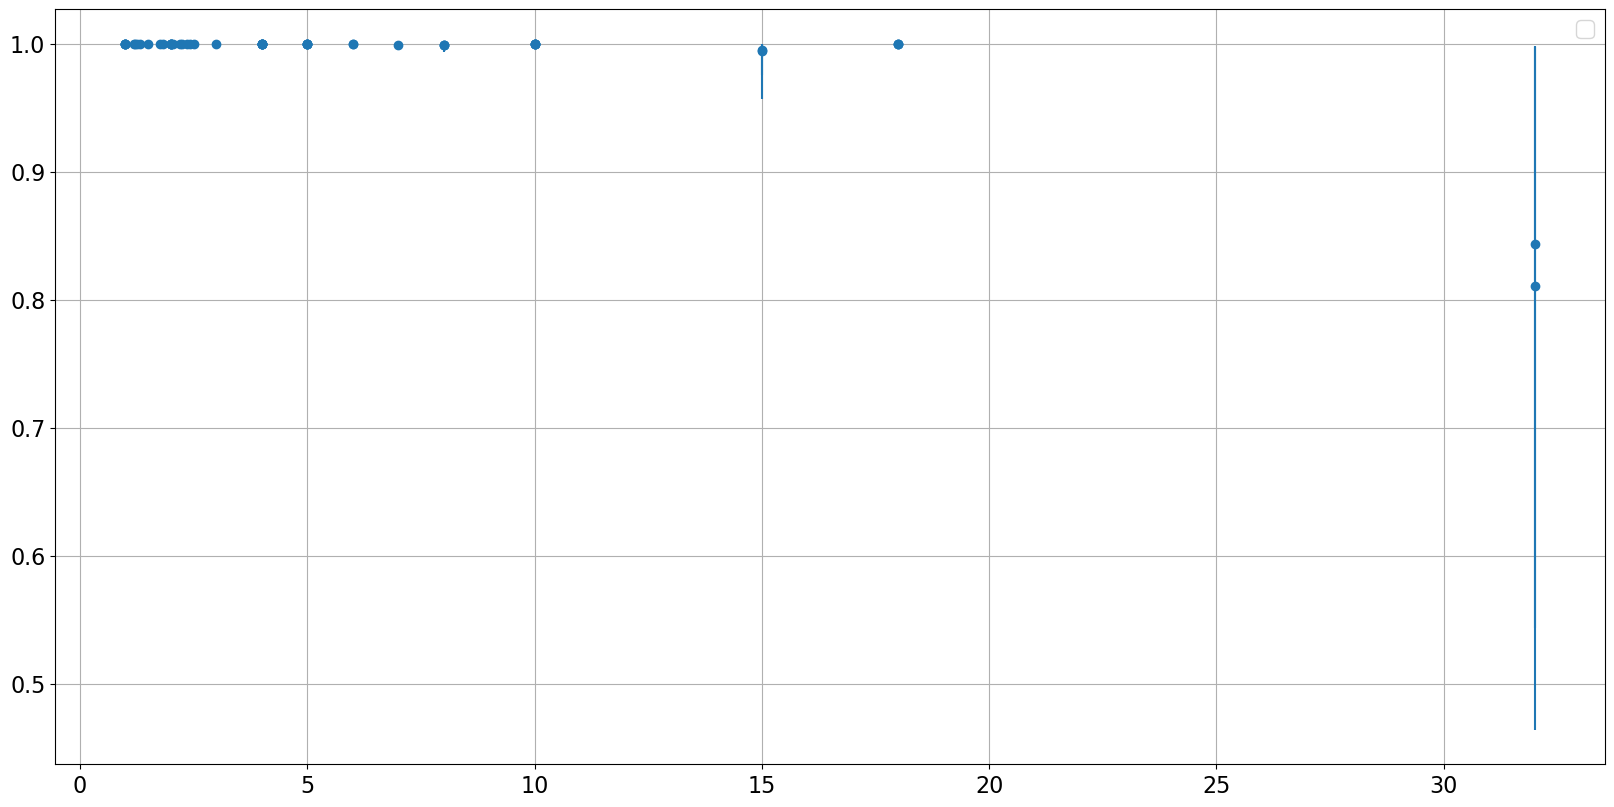

In [101]:


plt.figure(figsize=(20,10), dpi=100)
# plt.errorbar(df_results['q'], match_mu_est, yerr=match_err_est, fmt='o')
plt.errorbar(df_results['q'], match_mu_est, yerr=match_yerr, fmt='o')
plt.grid()
plt.legend()
# plt.ylim(0.99, 1.01)
# plt.yscale('log')
# plt.ylim(1e-8, 1)

In [102]:
phenprob_sampless_self_matches.std(1).shape

(54,)

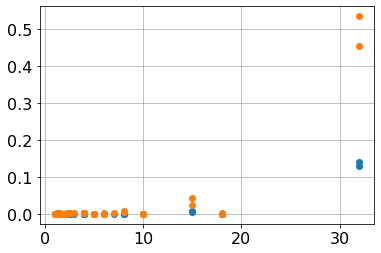

In [103]:
plt.figure()
plt.plot(df_results['q'], match_err_est, 'o')
plt.plot(df_results['q'], match_err_width, 'o')
plt.grid()

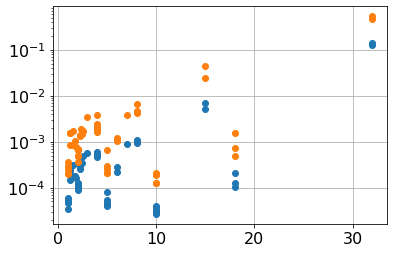

In [104]:
plt.figure()
plt.plot(df_results['q'], match_err_est, 'o')
plt.plot(df_results['q'], match_err_width, 'o')
plt.grid()
plt.yscale('log')

In [105]:
plt.figure(figsize=(20,10), dpi=100)
plt.violinplot(phenprob_samples_matches.T, positions=df['q'].values);
plt.plot(df_results['q'], df_results['mean_model'], 'x', c='k', markersize=10, label='mean model')


# plt.errorbar(df_results['q'], df_results['mean_model'], yerr=match_err_est, fmt='o')
# plt.errorbar(df_results['q'], match_mu_est, yerr=match_yerr, fmt='o')
plt.errorbar(df_results['q'], df_results['mean_model'], yerr=match_yerr, fmt='o')

plt.grid()
plt.title("match of model samples vs NR")
plt.legend()
plt.ylim(0.97, 1.01)
# plt.yscale('log')
# plt.ylim(1e-5, 1e-1)

(0.97, 1.01)

In [106]:
plt.figure(figsize=(20,10), dpi=100)
plt.violinplot(1-phenprob_samples_matches.T, positions=df['q'].values);
plt.plot(df_results['q'], 1-df_results['mean_model'], 'x', c='k', markersize=10, label='mean model')


plt.errorbar(df_results['q'], 1-df_results['mean_model'], yerr=match_err_est, fmt='o')

plt.grid()
plt.title("match of model samples vs NR")
plt.legend()
# plt.ylim(0.97, 1.01)
plt.yscale('log')
plt.ylim(1e-5, 1e-1)

(1e-05, 0.1)

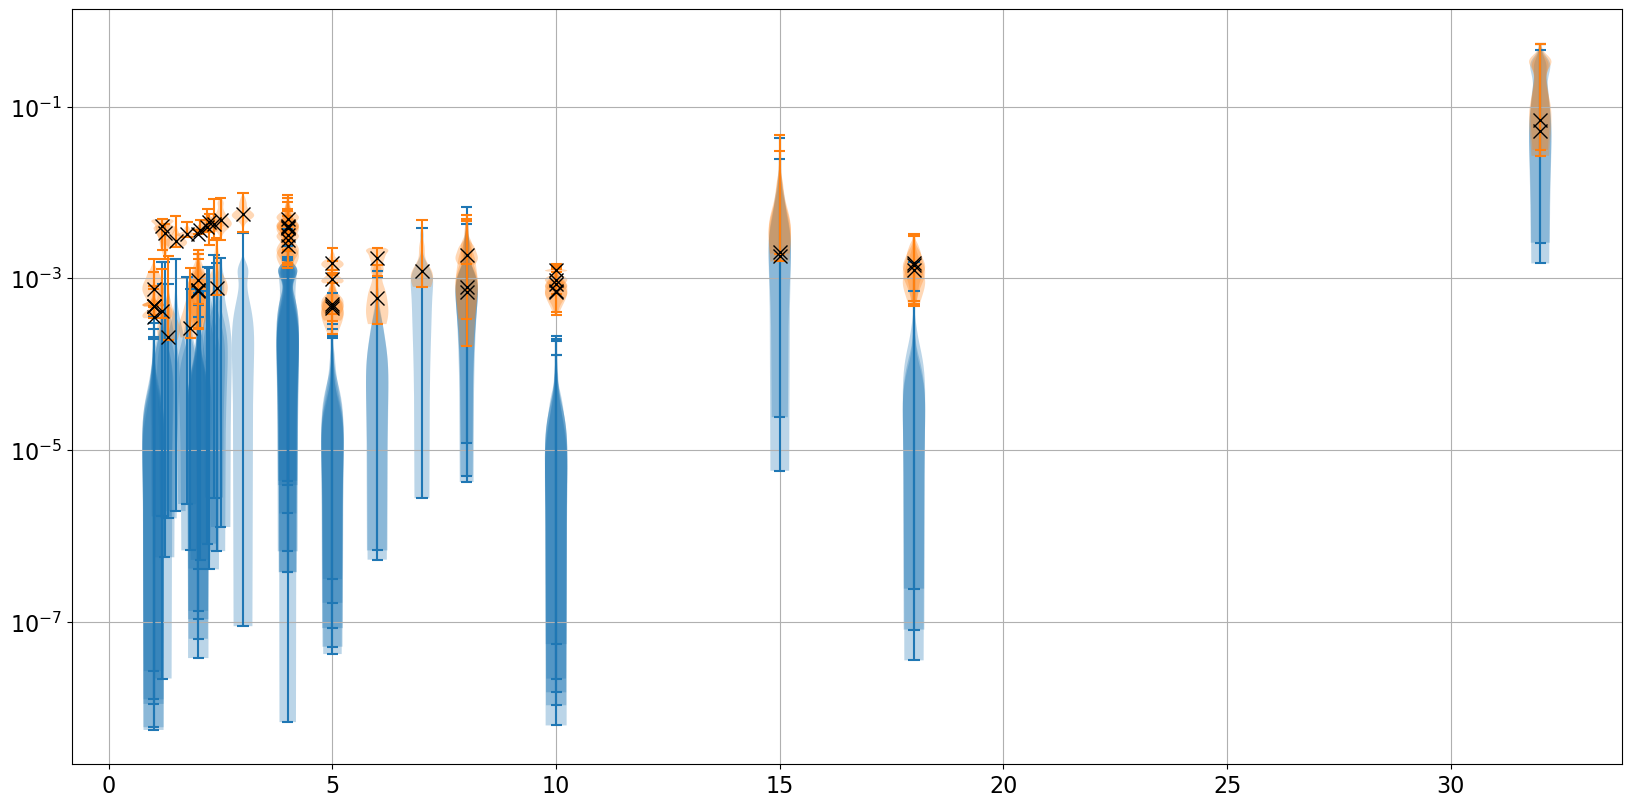

In [107]:
plt.figure(figsize=(20,10), dpi=100)
plt.violinplot(1-phenprob_sampless_self_matches.T, positions=df['q'].values); # mean model vs self samples (blue)
plt.violinplot(1-phenprob_samples_matches.T, positions=df['q'].values); # samples vs NR (orange)
plt.plot(df_results['q'], 1-df_results['mean_model'], 'x', c='k', markersize=10, label='mean model') # mean model vs NR (black)


plt.grid()
# plt.title("match of model samples vs model mean")
# plt.ylim(0.97, 1.01)
plt.yscale('log')
# plt.ylim(1e-5, 1e-1)

In [108]:
phenprob_samples_matches_min = phenprob_samples_matches.min(1)
phenprob_samples_matches_max = phenprob_samples_matches.max(1)
phenprob_samples_matches_width = phenprob_samples_matches_max - phenprob_samples_matches_min
phenprob_samples_matches_std = phenprob_samples_matches.std(1)
phenprob_samples_matches_mean =  phenprob_samples_matches.mean(1)

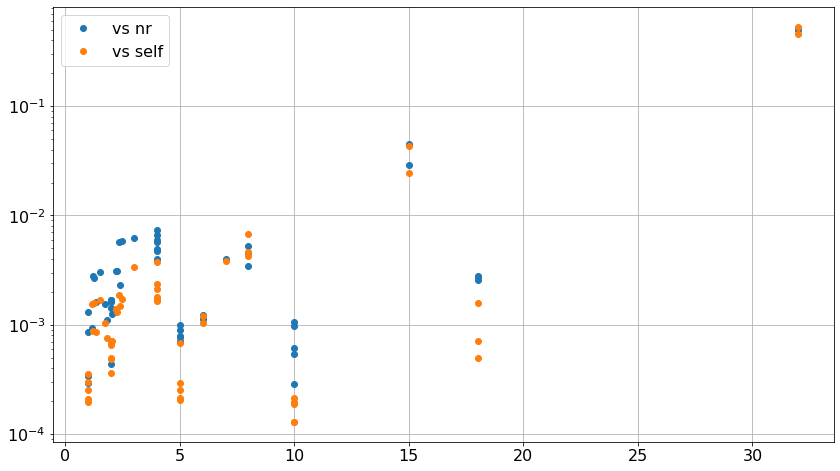

In [109]:
# compare the error estimate coming from computing the match between the mean model and samples from the model
# and
# samples of the model and NR waveforms
plt.figure(figsize=(14, 8))
plt.plot(df_results['q'], phenprob_samples_matches_width, 'o', label='vs nr')
plt.plot(df_results['q'], match_err_width, 'o', label='vs self')
plt.grid()
plt.yscale('log')
plt.legend()

In [110]:
# compare the error estimate coming from computing the match between the mean model and samples from the model
# and
# samples of the model and NR waveforms
plt.figure(figsize=(14, 8))
plt.plot(df_results['q'], phenprob_samples_matches_std, 'o', label='vs nr')
plt.plot(df_results['q'], match_err_est, 'o', label='vs self')
plt.grid()
plt.yscale('log')
plt.legend()

In [111]:
phenprob_sampless_self_matches_fine.shape

(195, 100)

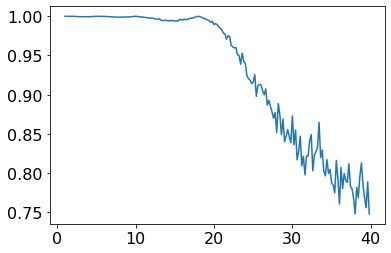

In [112]:
plt.plot(qs_fine, phenprob_sampless_self_matches_fine.mean(1))

In [113]:
plt.figure(figsize=(14, 6))
plt.plot(qs_fine, phenprob_sampless_self_matches_fine.std(1))

# for qi in df_results.query('set == "train"')['q'].unique():
#     plt.axvline(qi, c='k', ymax=0.1)

# for qi in df_results.query('set == "test"')['q'].unique():
#     plt.axvline(qi, c='r', ls='--', ymax=0.1)

    
train_idx = df_results.query('set == "train"').index
plt.plot(df_results['q'].iloc[train_idx], phenprob_samples_matches.std(1)[train_idx], 'o', mfc='none', markersize=8)


test_idx = df_results.query('set == "test"').index
plt.plot(df_results['q'].iloc[test_idx], phenprob_samples_matches.std(1)[test_idx], 'o', mfc='none', markersize=8)

plt.axhline(1-0.99, c='k')
plt.text(0.1, 0.015, "1% uncertainty", backgroundcolor='w', bbox=dict(facecolor='none', edgecolor='k', boxstyle='round,pad=0.2'), fontfamily='sans-serif')

plt.yscale('log')
plt.grid()
plt.title("model uncertainty std")
plt.xlabel("mass-ratio")
plt.ylabel(r"$\sigma(M)$");

(1e-05, 0.9)

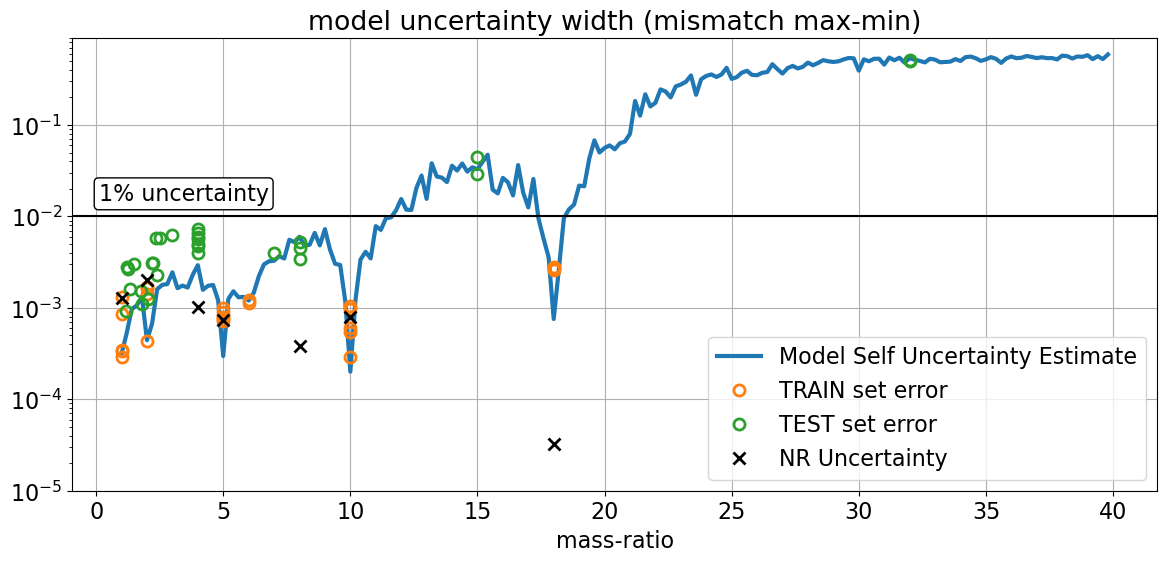

In [114]:
plt.figure(figsize=(14, 6), dpi=100)
w0 =  phenprob_sampless_self_matches_fine.max(1) - phenprob_sampless_self_matches_fine.min(1)
plt.plot(qs_fine, w0, label='Model Self Uncertainty Estimate', lw=3)

# for qi in df_results.query('set == "train"')['q'].unique():
#     plt.axvline(qi, c='k', ymax=0.1)

# for qi in df_results.query('set == "test"')['q'].unique():
#     plt.axvline(qi, c='r', ls='--', ymax=0.1)

    
train_idx = df_results.query('set == "train"').index
w1 = phenprob_samples_matches.max(1)[train_idx] - phenprob_samples_matches.min(1)[train_idx]
plt.plot(df_results['q'].iloc[train_idx], w1, 'o', mfc='none', markersize=8, label='TRAIN set error', markeredgewidth=2)


test_idx = df_results.query('set == "test"').index
w2 = phenprob_samples_matches.max(1)[test_idx] - phenprob_samples_matches.min(1)[test_idx]
plt.plot(df_results['q'].iloc[test_idx], w2, 'o', mfc='none', markersize=8, label='TEST set error', markeredgewidth=2)


w3 = df_nr_median['v_max'] - df_nr_median['v_min']
plt.plot(df_nr_median['q'], w3, 'kx', markersize=8, label='NR Uncertainty', markeredgewidth=2)

plt.axhline(1-0.99, c='k')
plt.text(0.1, 0.015, "1% uncertainty", backgroundcolor='w', bbox=dict(facecolor='w', edgecolor='k', boxstyle='round,pad=0.2'), fontfamily='sans-serif')

plt.yscale('log')
plt.grid()
plt.title("model uncertainty width (mismatch max-min)")
plt.xlabel("mass-ratio")

plt.legend(loc='lower right')

plt.ylim(1e-5, 9e-1)


# this plot shows the value of the max(match) - min(match) aggregated over
# samples from the phen_prob model
# as such it tells you a measure of the uncertainty of the model.
# we compare to other estimates e.g. coming from train and test set
# as well as NR vs NR calculations
# the blue line is the models self estimate

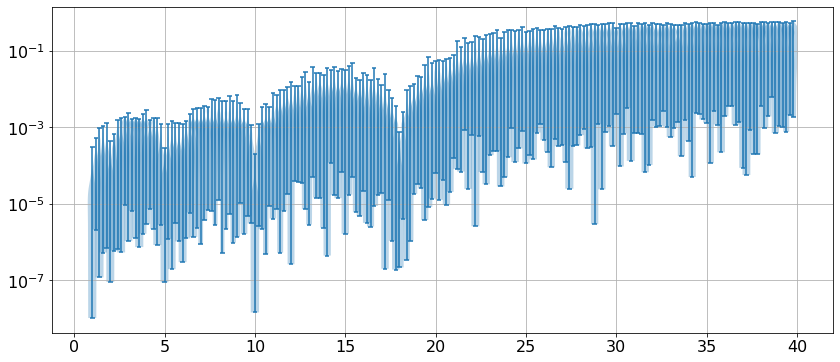

In [115]:
plt.figure(figsize=(14, 6))
plt.violinplot(1-phenprob_sampless_self_matches_fine.T, positions=qs_fine);
# plt.ylim(0.97,1.005)
plt.yscale('log')
plt.grid()

In [116]:
plt.figure(figsize=(14, 6))
mu = phenprob_sampless_self_matches_fine.mean(1)
y1 = phenprob_sampless_self_matches_fine.min(1)
y2 = phenprob_sampless_self_matches_fine.max(1)
plt.plot(qs_fine, mu)
plt.fill_between(qs_fine, y1=y1, y2=y2, alpha=0.5)

# for qi in df_results.query('set == "train"')['q'].unique():
#     plt.axvline(qi, c='k', ymax=0.1)

# for qi in df_results.query('set == "test"')['q'].unique():
#     plt.axvline(qi, c='r', ls='--', ymax=0.1)

    
train_idx = df_results.query('set == "train"').index
plt.plot(df_results['q'].iloc[train_idx], phenprob_samples_matches.mean(1)[train_idx], 'o', mfc='none', markersize=8)


test_idx = df_results.query('set == "test"').index
plt.plot(df_results['q'].iloc[test_idx], phenprob_samples_matches.mean(1)[test_idx], 'o', mfc='none', markersize=8)

# plt.yscale('log')
plt.grid()
plt.title("mean match")
plt.xlabel("mass-ratio")
plt.ylabel("mean M");
# plt.ylim(0.99,1.0001)

In [117]:
plt.figure(figsize=(14, 6))
mu = phenprob_sampless_self_matches_fine.mean(1)
y1 = phenprob_sampless_self_matches_fine.min(1)
y2 = phenprob_sampless_self_matches_fine.max(1)
plt.plot(qs_fine, mu)
plt.fill_between(qs_fine, y1=y1, y2=y2, alpha=0.5)

# for qi in df_results.query('set == "train"')['q'].unique():
#     plt.axvline(qi, c='k', ymax=0.1)

# for qi in df_results.query('set == "test"')['q'].unique():
#     plt.axvline(qi, c='r', ls='--', ymax=0.1)

    
train_idx = df_results.query('set == "train"').index
plt.plot(df_results['q'].iloc[train_idx], phenprob_samples_matches.mean(1)[train_idx], 'o', mfc='none', markersize=8)


test_idx = df_results.query('set == "test"').index
plt.plot(df_results['q'].iloc[test_idx], phenprob_samples_matches.mean(1)[test_idx], 'o', mfc='none', markersize=8)

# plt.yscale('log')
plt.grid()
plt.title("mean match")
plt.xlabel("mass-ratio")
plt.ylabel("mean M");
plt.ylim(0.94,1.001)
plt.xlim(0.5, 20)

(0.5, 20.0)

In [118]:
plt.figure(figsize=(14, 6))
mu = 1-phenprob_sampless_self_matches_fine.mean(1)
y1 = 1-phenprob_sampless_self_matches_fine.min(1)
y2 = 1-phenprob_sampless_self_matches_fine.max(1)
plt.plot(qs_fine, mu)
plt.fill_between(qs_fine, y1=y1, y2=y2, alpha=0.5)
# plt.fill_between(qs_fine, y1=mu, y2=y1, alpha=0.5)

# for qi in df_results.query('set == "train"')['q'].unique():
#     plt.axvline(qi, c='k', ymax=0.1)

# for qi in df_results.query('set == "test"')['q'].unique():
#     plt.axvline(qi, c='r', ls='--', ymax=0.1)

    
train_idx = df_results.query('set == "train"').index
plt.plot(df_results['q'].iloc[train_idx], 1-phenprob_samples_matches.mean(1)[train_idx], 'o', mfc='none', markersize=8)


test_idx = df_results.query('set == "test"').index
plt.plot(df_results['q'].iloc[test_idx], 1-phenprob_samples_matches.mean(1)[test_idx], 'o', mfc='none', markersize=8)

plt.yscale('log')
plt.grid()
plt.title("mean mismatch")
plt.xlabel("mass-ratio")
plt.ylabel("mean MM");
# plt.ylim(1e-7, 1)

In [119]:
phenprob_samples_matches.shape

(54, 100)

In [120]:
plt.figure(figsize=(14, 6), dpi=100)

train_idx = df_results.query('set == "train"').index
plt.violinplot(1-phenprob_samples_matches[train_idx].T, positions=df['q'].values[train_idx]); # samples vs NR (orange)
plt.plot(df_results['q'].iloc[train_idx], 1-df_results['mean_model'].iloc[train_idx], 'x', c='C0', markersize=10, label='TRAIN accuracy: match (mean model, NR)') # mean model vs NR (black)

test_idx = df_results.query('set == "test"').index
plt.violinplot(1-phenprob_samples_matches[test_idx].T, positions=df['q'].values[test_idx]); # samples vs NR (orange)
plt.plot(df_results['q'].iloc[test_idx], 1-df_results['mean_model'].iloc[test_idx], 'x', c='C1', markersize=10, label='TEST accuracy: match (mean model, NR)') # mean model vs NR (black)



# plt.fill_between(qs_fine, y1=mu, y2=y1, alpha=0.5)

# for qi in df_results.query('set == "train"')['q'].unique():
#     plt.axvline(qi, c='k', ymax=0.1)

# for qi in df_results.query('set == "test"')['q'].unique():
#     plt.axvline(qi, c='r', ls='--', ymax=0.1)

    
# train_idx = df_results.query('set == "train"').index
# plt.plot(df_results['q'].iloc[train_idx], 1-phenprob_samples_matches.mean(1)[train_idx], 'o', mfc='none', markersize=8)


# test_idx = df_results.query('set == "test"').index
# plt.plot(df_results['q'].iloc[test_idx], 1-phenprob_samples_matches.mean(1)[test_idx], 'o', mfc='none', markersize=8)

plt.plot(qs_fine, phenprob_sampless_self_matches_fine.std(1), label='self uncertainty estiamte', c='C2')

# NR vs NR best mismatch
# this is the estimate for NR solution error
# df_tmp=pd.DataFrame({'q':qs_nr, 'm':1-vals_nr}).groupby(by='q').min().reset_index()
# plt.plot(df_tmp['q'], df_tmp['m'], '_', markersize=20)


# plt.plot(df_nr_median['q'], 1-df_nr_median['v'], 'x', markersize=20, c='r')

y0_=1-df_nr_median['v']
yl=(1-df_nr_median['v'])-(1-df_nr_median['v_min'])
yp=(1-df_nr_median['v_max'])-(1-df_nr_median['v'])
plt.errorbar(df_nr_median['q'], y0_, yerr=[yl, yp], fmt='o', label='NR Uncertainty', c='k')



# can overlay other models but plot is so busy...
# other_model_min = df_results[['q','SEOBNRv4', 'TEOBResumS', 'IMRPhenomD', 'IMRPhenomT', 'IMRPhenomXP', 'NRSur7dq4']].groupby(by='q').min().min(1)
# other_model_mean = df_results[['q','SEOBNRv4', 'TEOBResumS', 'IMRPhenomD', 'IMRPhenomT', 'IMRPhenomXP', 'NRSur7dq4']].groupby(by='q').min().mean(1)
# other_model_max = df_results[['q','SEOBNRv4', 'TEOBResumS', 'IMRPhenomD', 'IMRPhenomT', 'IMRPhenomXP', 'NRSur7dq4']].groupby(by='q').min().max(1)
# plt.errorbar(other_model_max.index, 1-other_model_mean, yerr=[(1-other_model_mean)-(1-other_model_min), (1-other_model_max)-(1-other_model_mean)], c='r', fmt='o', alpha=0.5, label='other models')



plt.axhline(0.001, c='k', ls='--', alpha=0.5)
plt.axhline(0.01, c='k', ls='--', alpha=0.5)
plt.axhline(0.03, c='k', ls='--', alpha=0.5)

plt.yscale('log')
plt.grid()
plt.xlabel("mass-ratio")
# plt.title("Violin: Model Vs NR\n Green: Model's own estimate of uncertainty")

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='lower right')

# plt.ylim(1e-7, 1)
# plt.ylim(0.9,1)
# plt.xlim(0, 10)
# plt.xlim(10,40)

# this plot shows the mismatch of the model against the train and test set
# we also show the models selft estimate of uncertainty (which we have shown above seems to be a good indicator of uncertainty)
# we also show the NR vs NR matches (this is sorta like the current fundamental limit of the accuracy of any waveform model)

<ErrorbarContainer object of 3 artists>

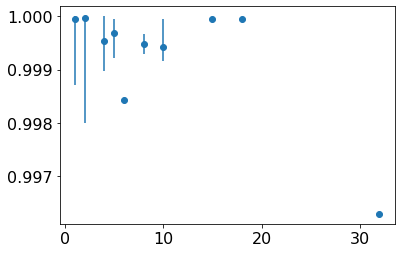

In [121]:
plt.errorbar(df_nr_median['q'], df_nr_median['v'], yerr=[df_nr_median['v']-df_nr_median['v_min'], df_nr_median['v_max']-df_nr_median['v']], fmt='o')

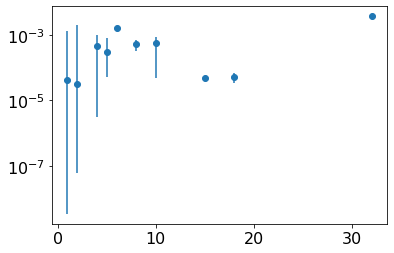

In [122]:
plt.errorbar(df_nr_median['q'], 1-df_nr_median['v'], yerr=[(1-df_nr_median['v'])-(1-df_nr_median['v_min']), (1-df_nr_median['v_max'])-(1-df_nr_median['v'])], fmt='o')
plt.yscale('log')

In [123]:
df_nr_median

q         v     v_min     v_max
0  18.0  0.999949  0.999933  0.999965
1   4.0  0.999536  0.998979  0.999997
2   8.0  0.999478  0.999289  0.999668
3  10.0  0.999431  0.999164  0.999952
4   5.0  0.999692  0.999218  0.999950
5   2.0  0.999968  0.997996  1.000000
6   1.0  0.999956  0.998714  1.000000
7  15.0  0.999951  0.999951  0.999951
8  32.0  0.996293  0.996293  0.996293
9   6.0  0.998424  0.998424  0.998424

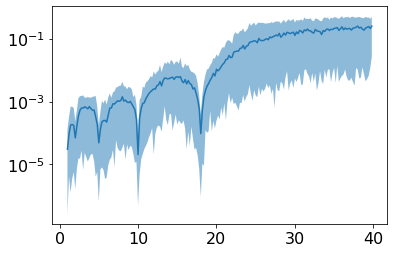

In [136]:


# plt.plot(qs_fine, phenprob_sampless_self_matches_fine.mean(1), label='self uncertainty estiamte', c='C2')
# plt.plot(qs_fine, phenprob_sampless_self_matches_fine.std(1), label='self uncertainty estiamte', c='C2')

zm = phenprob_sampless_self_matches_fine.mean(1)
zsd = phenprob_sampless_self_matches_fine.std(1)
zmin = phenprob_sampless_self_matches_fine.min(1)
zmax = phenprob_sampless_self_matches_fine.max(1)
# zl = zm - zsd
# zu = zm + zsd
zl = np.percentile(phenprob_sampless_self_matches_fine, 5, 1)
zu = np.percentile(phenprob_sampless_self_matches_fine, 95, 1)
plt.plot(qs_fine, 1-zm)
plt.fill_between(qs_fine, y1=1-zl, y2=1-zu, alpha=0.5)
plt.yscale('log')

In [ ]:
# plot should be match of mean with samples
# show mean +/- sd at each mass-ratio
# this is the accuracy self-estimate of phenprob?

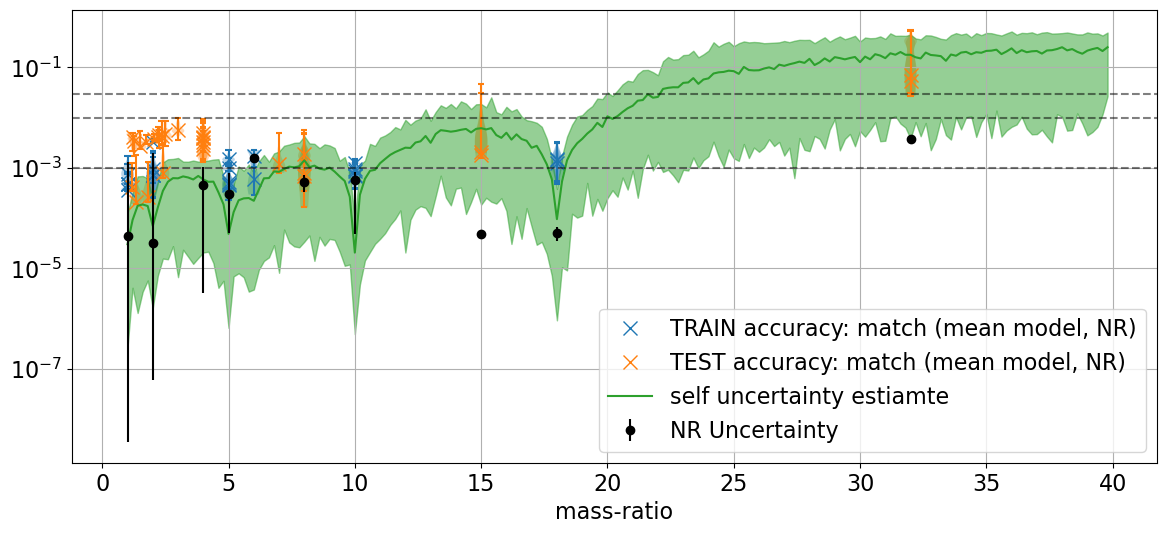

In [142]:
plt.figure(figsize=(14, 6), dpi=100)

train_idx = df_results.query('set == "train"').index
plt.violinplot(1-phenprob_samples_matches[train_idx].T, positions=df['q'].values[train_idx]); # samples vs NR (orange)
plt.plot(df_results['q'].iloc[train_idx], 1-df_results['mean_model'].iloc[train_idx], 'x', c='C0', markersize=10, label='TRAIN accuracy: match (mean model, NR)') # mean model vs NR (black)

test_idx = df_results.query('set == "test"').index
plt.violinplot(1-phenprob_samples_matches[test_idx].T, positions=df['q'].values[test_idx]); # samples vs NR (orange)
plt.plot(df_results['q'].iloc[test_idx], 1-df_results['mean_model'].iloc[test_idx], 'x', c='C1', markersize=10, label='TEST accuracy: match (mean model, NR)') # mean model vs NR (black)


# plt.plot(qs_fine, phenprob_sampless_self_matches_fine.std(1), label='self uncertainty estiamte', c='C2')

plt.plot(qs_fine, 1-zm, label='self uncertainty estiamte', c='C2')
plt.fill_between(qs_fine, y1=1-zl, y2=1-zu, alpha=0.5, color='C2')


y0_=1-df_nr_median['v']
yl=(1-df_nr_median['v'])-(1-df_nr_median['v_min'])
yp=(1-df_nr_median['v_max'])-(1-df_nr_median['v'])
plt.errorbar(df_nr_median['q'], y0_, yerr=[yl, yp], fmt='o', label='NR Uncertainty', c='k')


plt.axhline(0.001, c='k', ls='--', alpha=0.5)
plt.axhline(0.01, c='k', ls='--', alpha=0.5)
plt.axhline(0.03, c='k', ls='--', alpha=0.5)

plt.yscale('log')
plt.grid()
plt.xlabel("mass-ratio")
# plt.title("Violin: Model Vs NR\n Green: Model's own estimate of uncertainty")

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='lower right')


# plt.ylim(1e-7, 1)
# plt.ylim(0.9,1)
# plt.xlim(0, 10)
# plt.xlim(10,40)

# this plot shows the mismatch of the model against the train and test set
# we also show the models selft estimate of uncertainty (which we have shown above seems to be a good indicator of uncertainty)
# we also show the NR vs NR matches (this is sorta like the current fundamental limit of the accuracy of any waveform model)